<a href="https://colab.research.google.com/github/MichalRozenwald/epiCausality/blob/main/Extract_single_reads_%26_LR_2024Apr16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extracting single read mC profiles (using the new package)

# Colab setup

If you are running in Google Colab, run the cells below. **It is expected that Colab will make you restart your runtime to enable new package versions.**

In [12]:
%%time
# Lets Colab access your Google drive
try:
    from google.colab import drive
except:
    print("""
You don't seem to be running on Google Colab so this cell is not going to be useful for you.
Make sure you are running you notebook in a conda environment set up as per README.md.
Once you have this notebook running in a correctly configured environment, proceed to the rest of the cells.
          """)
else:
    drive.mount('/content/drive')
    # Install condacolab to let us get the modkit dependency
    !pip install -q condacolab
    import condacolab
    condacolab.install()
    # Install modkit
    !conda install nanoporetech::modkit==0.2.4
    # Clone the repo, change the active path to be inside the repo, and install the package
    !rm -r dimelo
    !git clone -b modkit_parsing_beta https://github.com/streetslab/dimelo
    import os
    os.chdir('dimelo')
    !pip install ipywidgets==7.7.1 .


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✨🍰✨ Everything looks OK!
Channels:
 - conda-forge
 - nanoporetech
Platform: linux-64
Solving environment: - \ | done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.3.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.

Cloning into 'dimelo'...
remote: Enumerating objects: 5456, done.
remote: Counting objects: 100% (1173/1173), done.
remote: Compressing objects: 100% (347/347), done.
remote: Total 5456 (delta 829), reused 1123 (delta 799), pack-reused 4283
Receiving objects: 100% (5456/5456), 206.38 MiB | 26.20 MiB/s, done.
Resolving deltas: 100% (3041/3041), done.
Processing /content/dimelo/dimelo
  Preparing metadata (setup.py) ... done
  Created wheel for dimelo: filename=dimelo-1.0.0-py3-none-any.whl size=29758 sha256

After runtime restart in previous cell, run this cell to make sure your notebook is set up.

In [16]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    import os
    os.chdir('/content/dimelo') # os.chdir('dimelo') #  -> change to  "os.chdir('/content/dimelo')"  or '/content/dimelo/dimelo'

except:
    pass


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
pwd

'/content/dimelo'

In [18]:
os.chdir('/content/dimelo')  # or '/content/dimelo/dimelo'
! pwd

/content/dimelo


# System and Versions Information

## Conda Environment

Run this cell to list the packages present in your conda environment

In [19]:
# !conda list

## System Information

Run this cell to list system information about your machine

In [20]:
import platform
print('System:',platform.system())
print('Release:',platform.release())
print('Version:',platform.version())
print('Processor:',platform.processor())

System: Linux
Release: 6.1.58+
Version: #1 SMP PREEMPT_DYNAMIC Sat Nov 18 15:31:17 UTC 2023
Processor: x86_64


## Git Repo Version

Run this cell to capture the exact repo version you're running, in case we need to debug anything

In [21]:
!git -C . log -1 --format=%H

019673c9cc52f9a58865566c3d4b19d07e7243e7


In [22]:
from pathlib import Path
from matplotlib import pyplot as plt
import pysam
import pandas as pd
from dimelo import plot_enrichment_profile, load_processed, parse_bam, utils

import seaborn as sns
from matplotlib.axes import Axes
import matplotlib.pyplot as plt

import numpy as np

# from . import load_processed
# from . import utils

# Download & Use the T2T v.1.1 -> for my Cas9 runs

In [7]:
! mkdir ./test/output/
!wget https://s3-us-west-2.amazonaws.com/human-pangenomics/T2T/CHM13/assemblies/chm13.draft_v1.1.fasta.gz -O ./test/output/chm13.draft_v1.1.fasta.gz
!gunzip ./test/output/chm13.draft_v1.1.fasta.gz

--2024-04-17 15:37:02--  https://s3-us-west-2.amazonaws.com/human-pangenomics/T2T/CHM13/assemblies/chm13.draft_v1.1.fasta.gz
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.92.238.208, 52.218.235.48, 52.92.131.176, ...
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.92.238.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 892637258 (851M) [binary/octet-stream]
Saving to: ‘./test/output/chm13.draft_v1.1.fasta.gz’

./test/output/chm13 100%[===================>] 851.29M  39.5MB/s    in 22s     

2024-04-17 15:37:24 (39.5 MB/s) - ‘./test/output/chm13.draft_v1.1.fasta.gz’ saved [892637258/892637258]



In [8]:
!pwd

/content/dimelo


In [23]:
from pathlib import Path
ref_genome_v1_1_file = Path('./test/output/chm13.draft_v1.1.fasta')
ref_genome_v1_1_file

PosixPath('test/output/chm13.draft_v1.1.fasta')

CCGCCCCGAGGCGCGCGCGCGCGCGCGCAC


<ipython-input-24-b25f586a1ad5>:22: RuntimeWarning: invalid value encountered in divide
  pileup_frac = mod_counts_vector / val_counts_vector


([<matplotlib.axis.XTick at 0x79c419670640>,
 [Text(0, 0, 'C'),
  Text(1, 0, 'C'),
  Text(2, 0, 'G'),
  Text(3, 0, 'C'),
  Text(4, 0, 'C'),
  Text(5, 0, 'C'),
  Text(6, 0, 'C'),
  Text(7, 0, 'G'),
  Text(8, 0, 'A'),
  Text(9, 0, 'G'),
  Text(10, 0, 'G'),
  Text(11, 0, 'C'),
  Text(12, 0, 'G'),
  Text(13, 0, 'C'),
  Text(14, 0, 'G'),
  Text(15, 0, 'C'),
  Text(16, 0, 'G'),
  Text(17, 0, 'C'),
  Text(18, 0, 'G'),
  Text(19, 0, 'C'),
  Text(20, 0, 'G'),
  Text(21, 0, 'C'),
  Text(22, 0, 'G'),
  Text(23, 0, 'C'),
  Text(24, 0, 'G'),
  Text(25, 0, 'C'),
  Text(26, 0, 'G'),
  Text(27, 0, 'C'),
  Text(28, 0, 'A'),
  Text(29, 0, 'C')])

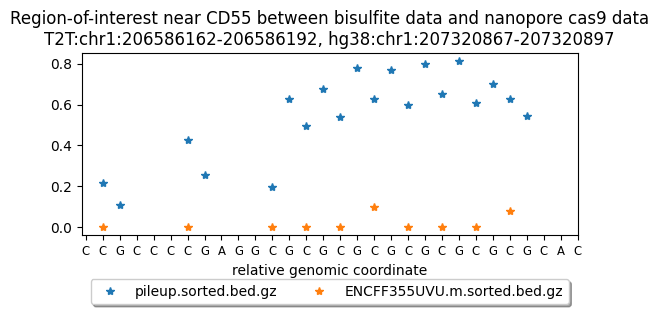

In [24]:
from matplotlib import pyplot as plt
t2t_cd55 = 'chr1:206586162-206586192'
hg38_cd55 = 'chr1:207320867-207320897'

# caspileup = '/Users/oberondixon-luinenburg/Documents/Ioannidis-Streets/dimelo_test_data/cd55_cas9/cd55_tss/pileup.sorted.bed.gz'
caspileup = '/content/drive/MyDrive/Michal Rozenwald/data/CD55/cas9_12ef_101923_misha/dimelo_new_package/cd55_tss_pileup_ws4000/pileup.sorted.bed.gz' # pileup
T_bedgz = Path('/content/drive/MyDrive/Michal Rozenwald/data/ENCODE/T_primary_ENCSR663MXB/ENCFF355UVU.m.sorted.bed.gz') #'/Users/oberondixon-luinenburg/Downloads/ENCFF279HCL.m.sorted.bed.gz')

from dimelo import plot_enrichment_profile
from dimelo import load_processed
import pysam

fig, ax = plt.subplots()

for file,region in zip([caspileup,T_bedgz],[t2t_cd55,hg38_cd55]):
    mod_counts_vector,val_counts_vector = load_processed.pileup_vectors_from_bedmethyl(
        bedmethyl_file = file,
        motif = 'CG,0',
        regions = region,
        window_size = None
    )
    pileup_frac = mod_counts_vector / val_counts_vector
    ax.plot(pileup_frac,'*',label=Path(file).name)

plt.title(f'Region-of-interest near CD55 between bisulfite data and nanopore cas9 data\nT2T:{t2t_cd55}, hg38:{hg38_cd55}')
plt.xlabel('relative genomic coordinate')
# plt.legend()
plt.subplots_adjust(bottom=0.5)  # Adjust the bottom
# Placing the legend at the bottom outside of the figure
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), shadow=True, ncol=2)

seq = pysam.FastaFile(ref_genome_v1_1_file).fetch('chr1',206586162,206586192)
print(seq)
seq_list =  [s for s in seq]
plt.xticks(range(len(seq_list)), seq_list, size='small')

<ipython-input-25-7c21e2259717>:37: RuntimeWarning: invalid value encountered in divide
  pileup_frac = mod_counts_vector / val_counts_vector


CCGCCCCGAGGCGCGCGCGCGCGCGCGCAC


([<matplotlib.axis.XTick at 0x79c41953bd00>,
 [Text(0, 0, 'C'),
  Text(1, 0, 'C'),
  Text(2, 0, 'G'),
  Text(3, 0, 'C'),
  Text(4, 0, 'C'),
  Text(5, 0, 'C'),
  Text(6, 0, 'C'),
  Text(7, 0, 'G'),
  Text(8, 0, 'A'),
  Text(9, 0, 'G'),
  Text(10, 0, 'G'),
  Text(11, 0, 'C'),
  Text(12, 0, 'G'),
  Text(13, 0, 'C'),
  Text(14, 0, 'G'),
  Text(15, 0, 'C'),
  Text(16, 0, 'G'),
  Text(17, 0, 'C'),
  Text(18, 0, 'G'),
  Text(19, 0, 'C'),
  Text(20, 0, 'G'),
  Text(21, 0, 'C'),
  Text(22, 0, 'G'),
  Text(23, 0, 'C'),
  Text(24, 0, 'G'),
  Text(25, 0, 'C'),
  Text(26, 0, 'G'),
  Text(27, 0, 'C'),
  Text(28, 0, 'A'),
  Text(29, 0, 'C')])

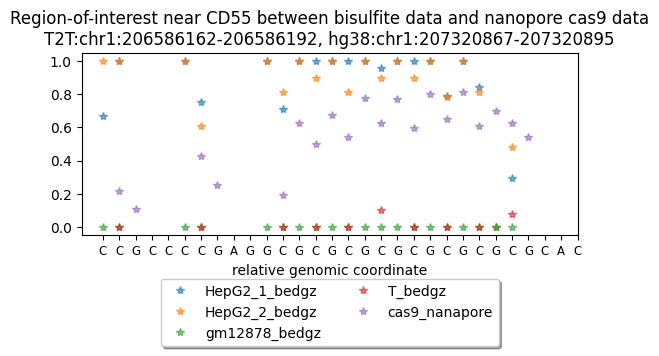

In [25]:
from matplotlib import pyplot as plt
t2t_cd55 = 'chr1:206586162-206586192'
hg38_cd55 = 'chr1:207320867-207320897'

# caspileup = '/Users/oberondixon-luinenburg/Documents/Ioannidis-Streets/dimelo_test_data/cd55_cas9/cd55_tss/pileup.sorted.bed.gz'
# caspileup = '/content/drive/MyDrive/Michal Rozenwald/data/CD55/cas9_12ef_101923_misha/dimelo_new_package/cd55_tss_pileup_ws4000/pileup.sorted.bed.gz' # pileup
# T_bedgz = Path('/content/drive/MyDrive/Michal Rozenwald/data/ENCODE/T_primary_ENCSR663MXB/ENCFF355UVU.m.sorted.bed.gz') #'/Users/oberondixon-luinenburg/Downloads/ENCFF279HCL.m.sorted.bed.gz')
hg38_cd55 = 'chr1:207320867-207320895'
gm12878_bedgz = Path('/content/drive/MyDrive/Michal Rozenwald/data/ENCODE/GM12878_ENCSR890UQO/ENCFF279HCL.m.sorted.bed.gz') #'/Users/oberondixon-luinenburg/Downloads/ENCFF279HCL.m.sorted.bed.gz')
HepG2_1_bedgz = Path('/content/drive/MyDrive/Michal Rozenwald/data/ENCODE/HepG2_ENCSR786DCL/ENCFF064GJQ.m.sorted.bed.gz') #'/Users/oberondixon-luinenburg/Downloads/ENCFF279HCL.m.sorted.bed.gz')
HepG2_2_bedgz = Path('/content/drive/MyDrive/Michal Rozenwald/data/ENCODE/HepG2_ENCSR786DCL/ENCFF369YQW.m.sorted.bed.gz') #'/Users/oberondixon-luinenburg/Downloads/ENCFF279HCL.m.sorted.bed.gz')

T_bedgz = Path('/content/drive/MyDrive/Michal Rozenwald/data/ENCODE/T_primary_ENCSR663MXB/ENCFF355UVU.m.sorted.bed.gz') #'/Users/oberondixon-luinenburg/Downloads/ENCFF279HCL.m.sorted.bed.gz')

t2t_cd55 = 'chr1:206586162-206586192'
# caspileup = '/Users/oberondixon-luinenburg/Documents/Ioannidis-Streets/dimelo_test_data/cd55_cas9/cd55_tss/pileup.sorted.bed.gz'
cas9_nanapore_bedgz = '/content/drive/MyDrive/Michal Rozenwald/data/CD55/cas9_12ef_101923_misha/dimelo_new_package/cd55_tss_pileup_ws4000/pileup.sorted.bed.gz' # pileup

from dimelo import plot_enrichment_profile
from dimelo import load_processed
import pysam

fig, ax = plt.subplots()


mod_file_names = [HepG2_1_bedgz, HepG2_2_bedgz, gm12878_bedgz, T_bedgz, cas9_nanapore_bedgz] # ,caspileup],
mod_file_names_label = ['HepG2_1_bedgz', 'HepG2_2_bedgz', 'gm12878_bedgz', 'T_bedgz', 'cas9_nanapore'] # ,caspileup],
regions_list = [hg38_cd55, hg38_cd55, hg38_cd55, hg38_cd55, t2t_cd55]

for file,region,label in zip(mod_file_names,regions_list, mod_file_names_label): # caspileup,T_bedgz],[t2t_cd55,hg38_cd55]):
    mod_counts_vector,val_counts_vector = load_processed.pileup_vectors_from_bedmethyl(
        bedmethyl_file = file,
        motif = 'CG,0',
        regions = region,
        window_size = None
    )
    pileup_frac = mod_counts_vector / val_counts_vector
    # ax.plot(pileup_frac,'*-',label=Path(file).name)
    ax.plot(pileup_frac,'*',label=label, alpha=0.6) # Path(file).name)

plt.title(f'Region-of-interest near CD55 between bisulfite data and nanopore cas9 data\nT2T:{t2t_cd55}, hg38:{hg38_cd55}')
plt.xlabel('relative genomic coordinate')
# plt.legend()
plt.subplots_adjust(bottom=0.5)  # Adjust the bottom
# Placing the legend at the bottom outside of the figure
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), shadow=True, ncol=2)

seq = pysam.FastaFile(ref_genome_v1_1_file).fetch('chr1',206586162,206586192)
print(seq)
seq_list =  [s for s in seq]
plt.xticks(range(len(seq_list)), seq_list, size='small')

Qs:
- How many reads there are in each of the datasets? So we know where the feq number is from and the general sense

In [26]:
from dimelo import load_processed
t2t_cd55 = 'chr1:206586162-206586192'
hg38_cd55 = 'chr1:207320867-207320895'
# caspileup = Path('/Users/oberondixon-luinenburg/Documents/Ioannidis-Streets/dimelo_test_data/cd55_cas9/cd55_tss/pileup.sorted.bed.gz')
# modified_bedgz = Path('/Users/oberondixon-luinenburg/Downloads/ENCFF279HCL.m.sorted.bed.gz')


gm12878_bedgz = Path('/content/drive/MyDrive/Michal Rozenwald/data/ENCODE/GM12878_ENCSR890UQO/ENCFF279HCL.m.sorted.bed.gz') #'/Users/oberondixon-luinenburg/Downloads/ENCFF279HCL.m.sorted.bed.gz')
modified_bedgz = gm12878_bedgz # T_bedgz
cas9_nanapore_bedgz = '/content/drive/MyDrive/Michal Rozenwald/data/CD55/cas9_12ef_101923_misha/dimelo_new_package/cd55_tss_pileup_ws4000/pileup.sorted.bed.gz' # pileup

for file,region in zip([cas9_nanapore_bedgz, gm12878_bedgz],[t2t_cd55,hg38_cd55]):
    mod_counts_vector,val_counts_vector = load_processed.pileup_vectors_from_bedmethyl(
        bedmethyl_file = file,
        motif = 'CG,0',
        regions = region,
        window_size = None
    )
    print(mod_counts_vector)
    print(val_counts_vector)

[  0  92  51   0   0   0 178 119   0   0   0  79 268 197 285 206 322 245
 313 229 326 249 315 234 261 237 179   0   0   0]
[  0 424 476   0   0   0 419 467   0   0   0 406 427 396 422 382 414 390
 406 383 408 382 388 386 373 379 329   0   0   0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[4 5 0 0 0 1 4 0 0 0 3 3 3 3 2 3 2 3 2 3 2 3 2 3 2 3 0 0]


In [27]:
206586162-206586192

-30

In [28]:
len(mod_counts_vector), mod_counts_vector

(28,
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]))

In [29]:
len(val_counts_vector), val_counts_vector

(28,
 array([4, 5, 0, 0, 0, 1, 4, 0, 0, 0, 3, 3, 3, 3, 2, 3, 2, 3, 2, 3, 2, 3,
        2, 3, 2, 3, 0, 0]))

In [30]:
from dimelo import load_processed
t2t_cd55 = 'chr1:206586162-206586192'
hg38_cd55 = 'chr1:207320867-207320895'
# caspileup = Path('/Users/oberondixon-luinenburg/Documents/Ioannidis-Streets/dimelo_test_data/cd55_cas9/cd55_tss/pileup.sorted.bed.gz')
# modified_bedgz = Path('/Users/oberondixon-luinenburg/Downloads/ENCFF279HCL.m.sorted.bed.gz')


gm12878_bedgz = Path('/content/drive/MyDrive/Michal Rozenwald/data/ENCODE/GM12878_ENCSR890UQO/ENCFF279HCL.m.sorted.bed.gz') #'/Users/oberondixon-luinenburg/Downloads/ENCFF279HCL.m.sorted.bed.gz')
cas9_nanapore = '/content/drive/MyDrive/Michal Rozenwald/data/CD55/cas9_12ef_101923_misha/dimelo_new_package/cd55_tss_pileup_ws4000/pileup.sorted.bed.gz' # pileup

for file,region in zip([cas9_nanapore, gm12878_bedgz],[t2t_cd55,hg38_cd55]):
    mod_counts_vector,val_counts_vector = load_processed.pileup_vectors_from_bedmethyl(
        bedmethyl_file = file,
        motif = 'CG,0',
        regions = region,
        window_size = None
    )
    print(mod_counts_vector)
    print(val_counts_vector)

[  0  92  51   0   0   0 178 119   0   0   0  79 268 197 285 206 322 245
 313 229 326 249 315 234 261 237 179   0   0   0]
[  0 424 476   0   0   0 419 467   0   0   0 406 427 396 422 382 414 390
 406 383 408 382 388 386 373 379 329   0   0   0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[4 5 0 0 0 1 4 0 0 0 3 3 3 3 2 3 2 3 2 3 2 3 2 3 2 3 0 0]


In [31]:
t2t_cd55 = 'chr1:206586162-206586192'


In [32]:
bam_cas9_12ef_101923_updated = "/content/drive/MyDrive/Michal Rozenwald/data/CD55/cas9_12ef_101923_misha/mc_only/cas9_12ef_101923_misha_mod_mappings.sorted_mC_only.updated.bam"
output_dir = Path('/content/drive/MyDrive/Michal Rozenwald/data/CD55/cas9_12ef_101923_misha/dimelo_new_package') # './test/output')

output_dir.mkdir(exist_ok=True)
output_dir

PosixPath('/content/drive/MyDrive/Michal Rozenwald/data/CD55/cas9_12ef_101923_misha/dimelo_new_package')

In [33]:
206586162-206586192

-30

# parse_bam.extract

In [34]:
t2t_cd55_30bps = 'chr1:206586162-206586192'

extract_file, extract_regions = parse_bam.extract(
    input_file=bam_cas9_12ef_101923_updated, # ctcf_bam_file_updated
    output_name='cas9_12ef_101923_extract_30bps_chr1_206586162_206586192_wsNone_thresh190', # _ws4000 'ctcf_demo_extract',
    ref_genome=ref_genome_v1_1_file, # ref_genome_file,
    output_directory=output_dir,
    regions=t2t_cd55_30bps, # [cd55_interest_target_regions], # ctcf_target_regions,ctcf_off_target_regions],
    motifs=['CG,0'], # ['A,0','CG,0'],
    thresh=190,
    window_size=None,

    # cores = 1, # uncomment this line if your process appears to be terminating early (reduces memory usage)
    # quiet = True,
    # cleanup = False,
    # log=True,
)

No specified number of cores requested. 2 available on machine, allocating all.
Modification threshold of 190 assumed to be for range 0-255. 190/255=0.7450980392156863 will be sent to modkit.


          | Preprocessing   0% | 00:00

          | Processing cas9_12ef_101923_misha_mod_mappings.sorted_mC_only.updated.bam   0% | 00:00<?

          |    0%

          | Transferring 920 from reads.CG,0.txt into reads.combined_basemods.h5, new size 920   0% | 00:00<?

In [35]:
read_data_list, datasets, _ = load_processed.read_vectors_from_hdf5(
    file=extract_file, # extract_file_no_thresh, # raw modification probabilities
    regions=t2t_cd55_30bps, # cd55_30bps_interest_coords, # ctcf_target_regions,
    motifs=['CG,0'], # 'A,0'],
    window_size=None,
)
# Print out the data from the first read
for idx,dataset in enumerate(datasets):
    print(dataset)
    for read_data in read_data_list:
        print('\t',read_data[idx])
        break

chromosome
	 chr1
mod_vector
	 [False False False ... False False  True]
motif
	 CG,0
read_end
	 206590113
read_name
	 9343e1fe-dfbc-4434-b969-95a0ee2bd0f2
read_start
	 206583052
strand
	 +
val_vector
	 [False False False ...  True False  True]
region_start
	 206586162
region_end
	 206586192
CG,0_mod_fraction
	 0.5


In [36]:
read_data_list

[('chr1',
  array([False, False, False, ..., False, False,  True]),
  'CG,0',
  206590113,
  '9343e1fe-dfbc-4434-b969-95a0ee2bd0f2',
  206583052,
  '+',
  array([False, False, False, ...,  True, False,  True]),
  206586162,
  206586192,
  0.5),
 ('chr1',
  array([False, False, False, ..., False, False, False]),
  'CG,0',
  206589926,
  'b69854bc-ff64-4b07-bf2e-b05edf6385ba',
  206583052,
  '+',
  array([False, False, False, ...,  True, False,  True]),
  206586162,
  206586192,
  0.1),
 ('chr1',
  array([False, False, False, ..., False, False, False]),
  'CG,0',
  206589931,
  '4a9708df-dfb6-4e6f-8795-a6f3e697e947',
  206583052,
  '+',
  array([False, False, False, ...,  True, False,  True]),
  206586162,
  206586192,
  0.3),
 ('chr1',
  array([False, False, False, ..., False, False, False]),
  'CG,0',
  206589933,
  '51a762b4-5376-49f0-8d2d-32fe9a21236f',
  206583052,
  '+',
  array([False, False, False, ..., False, False,  True]),
  206586162,
  206586192,
  0.0),
 ('chr1',
  array([F

In [37]:
len(read_data_list)

920

# Calculate unique reads

In [38]:
read_names_all = []
read_start_all = []
read_end_all = []

for read_data in read_data_list:
    # print('\t',read_data[4]) # read_name
    read_names_all.append(read_data[4])  # read_name
    read_start_all.append(read_data[8])  # read_start
    read_end_all.append(read_data[3])  # read_end


In [39]:
read_names_all, read_start_all, read_end_all = np.array(read_names_all), np.array(read_start_all), np.array(read_end_all)
read_names_all, read_start_all, read_end_all


(array(['9343e1fe-dfbc-4434-b969-95a0ee2bd0f2',
        'b69854bc-ff64-4b07-bf2e-b05edf6385ba',
        '4a9708df-dfb6-4e6f-8795-a6f3e697e947',
        '51a762b4-5376-49f0-8d2d-32fe9a21236f',
        '98feb4c6-8f87-47ec-bebf-1734bfff7f1c',
        '0f79e159-e3f9-40ee-bc09-daa6b868d45b',
        '26b64d98-d9f6-4a22-b4f6-14ca873e7cbf',
        '6e71a554-f1c3-47bc-b5b6-639ad1f6d661',
        'e00e7b81-d121-425b-9d0a-75ab768e502d',
        '2e63986d-6dd3-417b-a7f7-2c66540b32c5',
        'af025a94-ab95-4f2c-b042-c12d634728d8',
        '8a004ffb-814d-4312-ab42-c451390ec6cf',
        '1e75f8e1-5dc1-42ae-863d-9f5d24006d91',
        '13bc52dd-65c6-450a-becd-341f0284a96c',
        '530c7c1b-c7fc-466c-b291-a18c6bcf5626',
        '6ed810e6-6adc-4173-ad3a-4a4f61ed8cee',
        '021fca2f-b2d7-404b-a2a4-ee0130e88ab0',
        'c64411e6-76d2-43c3-ae14-82fa1374b469',
        '7c7b7b07-2cc2-459a-9f56-dcc6ac45a75f',
        'cabbed73-a5d5-43c1-a4df-ea5f53325e29',
        '005fffe9-cf23-4fff-9bb5-48ede50

In [40]:
len(np.unique(read_names_all))

920

In [41]:
datasets

['chromosome',
 'mod_vector',
 'motif',
 'read_end',
 'read_name',
 'read_start',
 'strand',
 'val_vector',
 'region_start',
 'region_end',
 'CG,0_mod_fraction']

In [42]:
read_data_list[0]

('chr1',
 array([False, False, False, ..., False, False,  True]),
 'CG,0',
 206590113,
 '9343e1fe-dfbc-4434-b969-95a0ee2bd0f2',
 206583052,
 '+',
 array([False, False, False, ...,  True, False,  True]),
 206586162,
 206586192,
 0.5)

In [43]:
read_data_list[0][0] #['mod_vector']

'chr1'

In [44]:
read_data_list[0][1] #['mod_vector']

array([False, False, False, ..., False, False,  True])

In [45]:
len(read_data_list[0][1])

3136

In [46]:
read_start = read_data_list[0][5] #['read_start']
read_start

206583052

In [47]:
read_end = read_data_list[0][3] #['read_end']
read_end

206590113

In [48]:
read_end - read_start

7061

> Don't extract the subsection of the read of interest -> just save the whole read?..

#TODO: need to extract the subvectors?

In [49]:
# readwise_binary_modification_arrays(
#     file: str | Path,
#     motifs: list[str],
#     regions: str | Path | list[str|Path],
#     window_size: int = None,
#     sort_by: str | list[str] = ['chromosome','region_start','read_start'],
#     thresh: float = None,
#     relative: bool = True,
# ) -> tuple[list[np.ndarray], np.ndarray[int], np.ndarray[str]]:
#     """
#     Pulls a list of read data out of a file containing processed read vectors, formatted with
#     seaborn plotting in mind. Currently we only support .h5 files.

#     Args:
#         file: Path to an hdf5 (.h5) file containing modification data for single reads,
#             stored in datasets read_name, chromosome, read_start,
#             read_end, base modification motif, mod_vector, and val_vector.
#         regions: Single or list of Path objects or strings. Path objects must point to .bed
#             files, strings can be .bed paths or region string in the format chrX:XXX-XXX.
#             All should all be regions for which your original .bam file had reads extracted,
#             although by design this method will not raise an error if any region contains
#             zero reads, as this may simply be a matter of low read depth.
#         motifs: types of modification to extract data for. Motifs are specified as
#             {DNA_sequence},{position_of_modification}. For example, a methylated adenine is specified
#             as 'A,0' and CpG methylation is specified as 'CG,0'.
#         window_size: An optional parameter for creating centered windows for the provided regions.
#             If provided, all regions will be adjusted to be the same size and centered. If not provided,
#             all regions should already be the same size, or there should be only one.
#         sort_by: Read properties by which to sort, either one string or a list of strings. Options
#             include chromosome, region_start, region_end, read_start, read_end, and motif. More to
#             be added in future.
#         thresh: A modification calling threshold. If the .h5 is already modification-called, this does
#             nothing. If the .h5 files is not modification-called, i.e. its modification data is saved
#             as floating point array, thresh must be provided to have valid binary outputs.
#         relative: If True, modification coordinates are specified relative to their respective regions
#             in the genomes, centered at the center of the region. If False, absolute coordinates are provided.
#             There is not currently a check for all reads being on the same chromosome if relative=False, but
#             this could create unexpected behaviour for a the standard visualizations.

#     Returns:
#         Returns a tuple of three arrays, of length (N_READS * len(mod_names)), and a dict of regions.
#         The arrays contain the following:
#         * positions at which the specified modification was found in a read, after a binary call
#         * unique integer ID for the read for each modification position. These integers are ordered
#             based on the specified sorting.
#         * modification represented by the positions, in the motif format
#         The regions_dict contains the following:
#         * keys: chromosomes/contigs
#         * values: lists of tuples in the format (region_start,region_end)
#         For example, if called on a dataset with a single read and two modification types, each array would have two entries. The unique IDs would be the same, as both entries would represent the same single read. The mods and positions would be different, as they would extact different mods.
#     """

In [50]:
# from dimelo import readwise_binary_modification_arrays

# np.array(mod_coords_list),np.array(read_ints_list),np.array(motifs_list),regions_dict -

mod_coords_list, read_ints_list, motifs_list,regions_dict = load_processed.readwise_binary_modification_arrays(
    extract_file, # extract_file_no_thresh, # raw modification probabilities
    regions=t2t_cd55_30bps, # cd55_30bps_interest_coords, # ctcf_target_regions,
    motifs=['CG,0'], # 'A,0'],
)
# file: str | Path,
#     motifs: list[str],
#     regions: str | Path | list[str|Path],
#     window_size: int = None,
#     sort_by: str | list[str] = ['chromosome','region_start','read_start'],
#     thresh: float = None,
#     relative: bool = True,
# )

In [51]:
mod_coords_list,read_ints_list, motifs_list,regions_dict

(array([-2,  0,  2, ...,  7,  9, 11]),
 array([  0,   0,   0, ..., 919, 919, 919]),
 array(['CG,0', 'CG,0', 'CG,0', ..., 'CG,0', 'CG,0', 'CG,0'], dtype='<U4'),
 defaultdict(list, {'chr1': [(206586162, 206586192, '.')]}))

In [52]:
mod_coords_list

array([-2,  0,  2, ...,  7,  9, 11])

In [53]:
len(mod_coords_list)

2405

In [54]:
(len(mod_coords_list) /  (206586162 - 206586192))

-80.16666666666667

In [55]:
len(mod_coords_list /  (206586162 - 206586192))

2405

In [56]:
len(mod_coords_list)

2405

In [57]:
read_ints_list

array([  0,   0,   0, ..., 919, 919, 919])

In [58]:
motifs_list

array(['CG,0', 'CG,0', 'CG,0', ..., 'CG,0', 'CG,0', 'CG,0'], dtype='<U4')

In [59]:
regions_dict

defaultdict(list, {'chr1': [(206586162, 206586192, '.')]})

In [60]:
206586162 - 206586192

-30

<Axes: xlabel='pos', ylabel='read_name'>

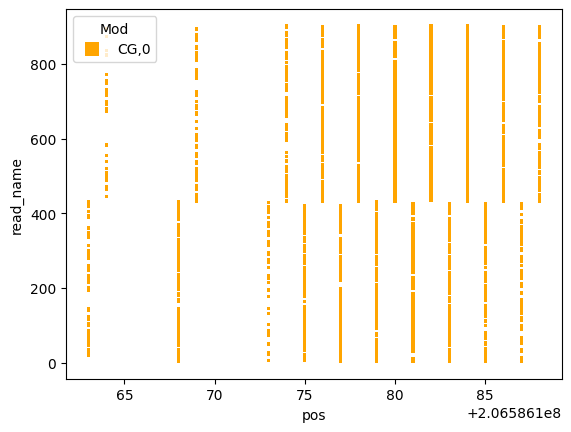

In [61]:
from matplotlib import pyplot as plt
from dimelo import plot_reads

plot_reads.plot_reads(
    extract_file, # extracted_h5,
    regions = 'chr1:206582520-206585020',
    motifs = ['CG,0'],
    thresh = 0.75,
    sort_by = ['shuffle','strand'],
    relative = False,
    window_size = None, # 5000,
    s=5,
)
# plt.xlim(206582520,206585020)


# seq = pysam.FastaFile(ref_genome_v1_1_file).fetch('chr1',206586162,206586192)
# print(seq)
# seq_list =  [s for s in seq]
# plt.xticks(range(len(seq_list)), seq_list, size='small')

In [62]:
# from matplotlib import pyplot as plt
# from dimelo import plot_reads

# plot_reads.plot_reads(
#     extract_file, # extracted_h5,
#     regions = 'chr1:206582520-206585020',
#     motifs = ['CG,0'],
#     thresh = 0.75,
#     sort_by = ['shuffle','strand'],
#     relative = False,
#     window_size = 5000,
#     s=5,
# )
# plt.xlim(206582520,206585020)

<Axes: xlabel='pos', ylabel='read_name'>

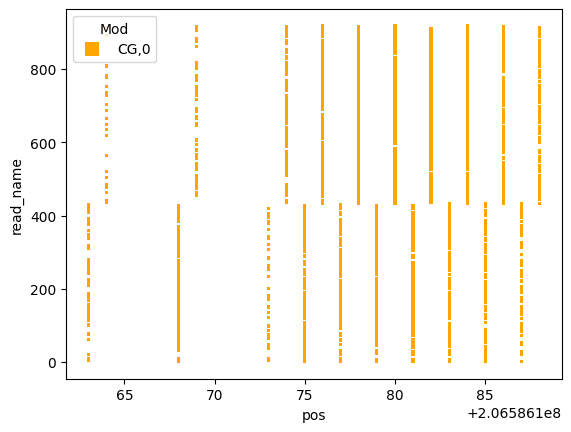

In [63]:
from matplotlib import pyplot as plt
from dimelo import plot_reads

plot_reads.plot_reads(
    extract_file, # extracted_h5,
    regions = 'chr1:206582520-206585020',
    motifs = ['CG,0'],
    thresh = 0.75,
    sort_by = ['shuffle','strand'],
    relative = False,
    window_size =  5000, # None, #
    s=5,
)
# plt.xlim(206582520,206585020)


# seq = pysam.FastaFile(ref_genome_v1_1_file).fetch('chr1',206586162,206586192)
# print(seq)
# seq_list =  [s for s in seq]
# plt.xticks(range(len(seq_list)), seq_list, size='small')

In [64]:
# chr1_
206586162-206586192

-30

In [65]:
# ref_genome_v1_1_file
window_size = 4000
outname = f'cd55_window{window_size}'
num_cores = 32

# cas9 = parse_bam.extract(
#     input_file=bam_cas9_12ef_101923_updated, # cd55_filepath,
#     output_name=outname,
#     ref_genome=ref_genome_v1_1_file, # '/clusterfs/nilah/oberon/genomes/chm13.draft_v1.1.fasta',
#     regions=t2t_cd55_30bps, # bed_files="chr1:206586162-206586192", # [bed_region],
#     basemods=['CG,0'],
#     cores=num_cores,
#     thresh=0.75,
#     window_size=window_size,
# )
t2t_cd55_30bps = 'chr1:206586162-206586192'

# = extract_file, extract_regions
cas9  = parse_bam.extract(
    input_file=bam_cas9_12ef_101923_updated, # ctcf_bam_file_updated
    output_name='cas9_12ef_101923_extract_chr1_206586162_206586192_ws4000_thresh075', # _ws4000 'ctcf_demo_extract',
    ref_genome=ref_genome_v1_1_file, # ref_genome_file,
    output_directory=output_dir,
    regions=t2t_cd55_30bps, # [cd55_interest_target_regions], # ctcf_target_regions,ctcf_off_target_regions],
    motifs=['CG,0'], # ['A,0','CG,0'],
    thresh=0.75, # 190,
    window_size=window_size, # None,
    # cores = 1, # uncomment this line if your process appears to be terminating early (reduces memory usage)
    # quiet = True,
    # cleanup = False,
    # log=True,
)


No specified number of cores requested. 2 available on machine, allocating all.
Modification threshold of 0.75 will be treated as coming from range 0-1.


          | Preprocessing   0% | 00:00

          | Processing cas9_12ef_101923_misha_mod_mappings.sorted_mC_only.updated.bam   0% | 00:00<?

          |    0%

          | Transferring 1047 from reads.CG,0.txt into reads.combined_basemods.h5, new size 1047   0% | 00:00<…

In [66]:
extract_file_ws4000, extract_regions_ws4000 = cas9
extract_file_ws4000

PosixPath('/content/drive/MyDrive/Michal Rozenwald/data/CD55/cas9_12ef_101923_misha/dimelo_new_package/cas9_12ef_101923_extract_chr1_206586162_206586192_ws4000_thresh075/reads.combined_basemods.h5')

Text(0.5, 1.0, 'cas9_12ef_101923_misha_mod_mappings.retagged.sorted_mC_only.bam CpG extraction')

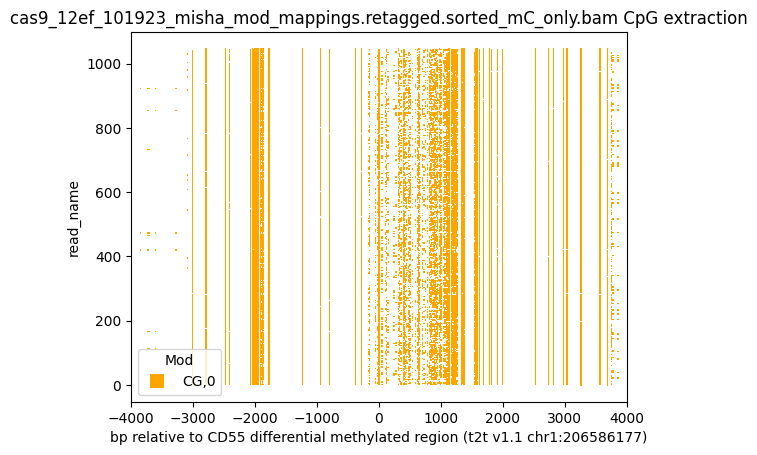

In [67]:
plot_reads.plot_reads(
    extract_file_ws4000, # cas9,
    "chr1:206586162-206586192", # bed_region,
    ['CG,0'],
    window_size = 4000,
    s=1)
plt.xlabel('bp relative to CD55 differential methylated region (t2t v1.1 chr1:206586177)')
plt.title('cas9_12ef_101923_misha_mod_mappings.retagged.sorted_mC_only.bam CpG extraction')

In [68]:
extract_file_ws4000

PosixPath('/content/drive/MyDrive/Michal Rozenwald/data/CD55/cas9_12ef_101923_misha/dimelo_new_package/cas9_12ef_101923_extract_chr1_206586162_206586192_ws4000_thresh075/reads.combined_basemods.h5')

Text(0.5, 1.0, 'cas9_12ef_101923_misha_mod_mappings.retagged.sorted_mC_only.bam CpG extraction')

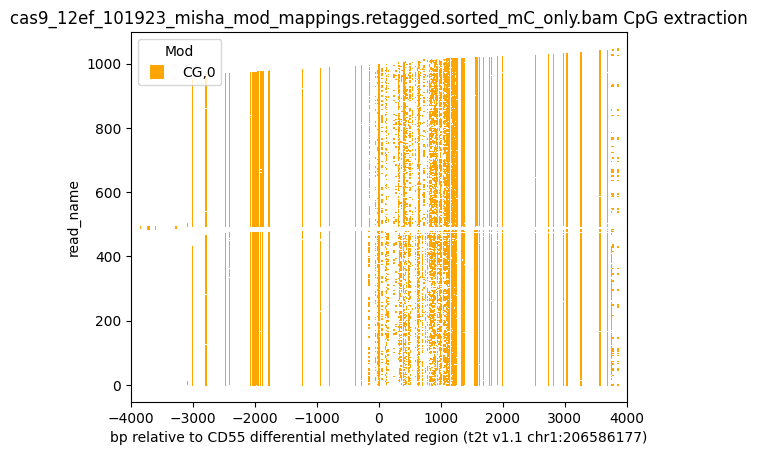

In [69]:
plot_reads.plot_reads(
    extract_file_ws4000, # cas9,
    "chr1:206586162-206586192", # bed_region,
    ['CG,0'],
    window_size = 4000,
    sort_by = ['strand'], # ['shuffle','strand'],
    # sort_by = ['shuffle', 'strand', 'region_start'], # ['shuffle','strand'],
    s=1)
plt.xlabel('bp relative to CD55 differential methylated region (t2t v1.1 chr1:206586177)')
plt.title('cas9_12ef_101923_misha_mod_mappings.retagged.sorted_mC_only.bam CpG extraction')



# Sort reads by the region start

Text(0.5, 1.0, 'cas9_12ef_101923_misha_mod_mappings.retagged.sorted_mC_only.bam CpG extraction')

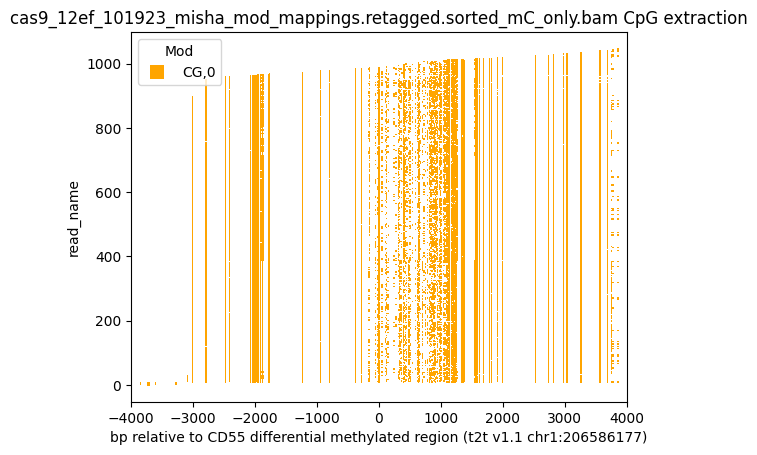

In [70]:
plot_reads.plot_reads(
    extract_file_ws4000, # cas9,
    "chr1:206586162-206586192", # bed_region,
    ['CG,0'],
    window_size = 4000,
    sort_by = ['region_start'], # ['shuffle','strand'],
    # sort_by = ['shuffle', 'strand', 'region_start'], # ['shuffle','strand'],
    s=1)
plt.xlabel('bp relative to CD55 differential methylated region (t2t v1.1 chr1:206586177)')
plt.title('cas9_12ef_101923_misha_mod_mappings.retagged.sorted_mC_only.bam CpG extraction')



Text(0.5, 1.0, 'cas9_12ef_101923_misha_mod_mappings.retagged.sorted_mC_only.bam CpG extraction')

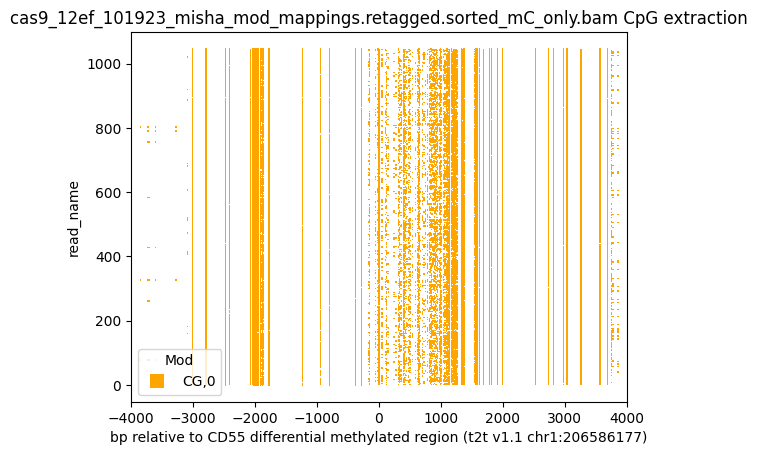

In [71]:
plot_reads.plot_reads(
    extract_file_ws4000, # cas9,
    "chr1:206586162-206586192", # bed_region,
    ['CG,0'],
    window_size = 4000,
    sort_by = ['region_start', 'shuffle'], # ['shuffle','strand'],
    # sort_by = ['shuffle', 'strand', 'region_start'], # ['shuffle','strand'],
    s=1)
plt.xlabel('bp relative to CD55 differential methylated region (t2t v1.1 chr1:206586177)')
plt.title('cas9_12ef_101923_misha_mod_mappings.retagged.sorted_mC_only.bam CpG extraction')



Text(0.5, 1.0, 'cas9_12ef_101923_misha_mod_mappings.retagged.sorted_mC_only.bam CpG extraction')

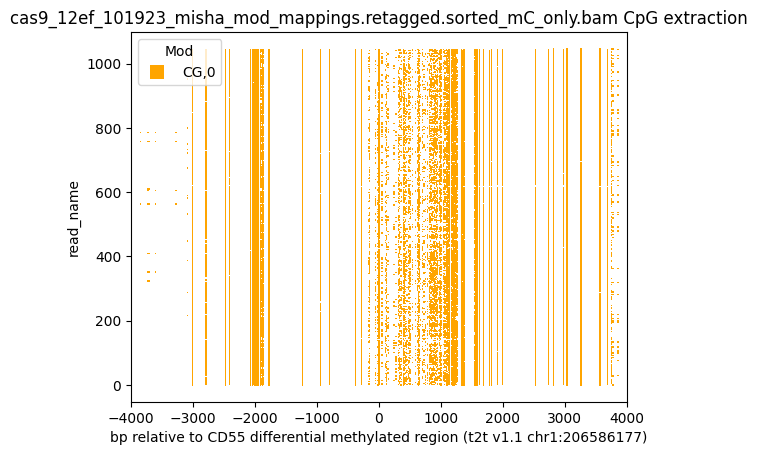

In [72]:
plot_reads.plot_reads(
    extract_file_ws4000, # cas9,
    "chr1:206586162-206586192", # bed_region,
    ['CG,0'],
    window_size = 4000,
    sort_by = ['region_start', 'shuffle'], # ['shuffle','strand'],
    # sort_by = ['shuffle', 'strand', 'region_start'], # ['shuffle','strand'],
    s=1)
plt.xlabel('bp relative to CD55 differential methylated region (t2t v1.1 chr1:206586177)')
plt.title('cas9_12ef_101923_misha_mod_mappings.retagged.sorted_mC_only.bam CpG extraction')



Text(0.5, 1.0, 'cas9_12ef_101923_misha_mod_mappings.retagged.sorted_mC_only.bam CpG extraction')

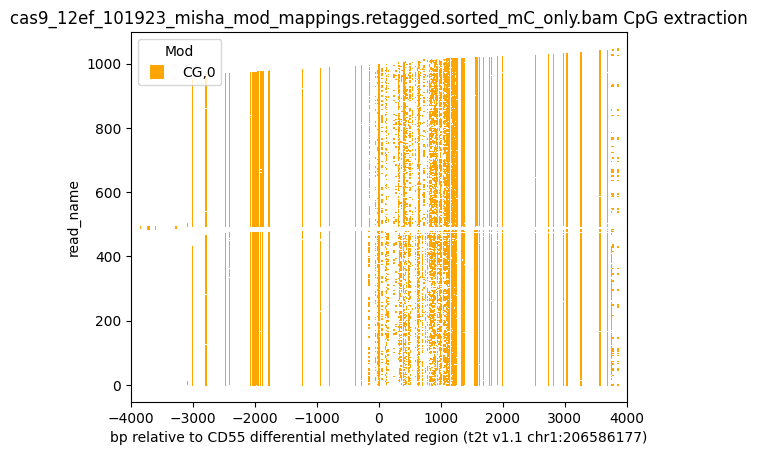

In [73]:
plot_reads.plot_reads(
    extract_file_ws4000, # cas9,
    "chr1:206586162-206586192", # bed_region,
    ['CG,0'],
    window_size = 4000,
    sort_by = ['region_start', 'strand'], # ['shuffle','strand'],
    # sort_by = ['shuffle', 'strand', 'region_start'], # ['shuffle','strand'],
    s=1)
plt.xlabel('bp relative to CD55 differential methylated region (t2t v1.1 chr1:206586177)')
plt.title('cas9_12ef_101923_misha_mod_mappings.retagged.sorted_mC_only.bam CpG extraction')



CCGCCCCGAGGCGCGCGCGCGCGCGCGCAC


([<matplotlib.axis.XTick at 0x79c415d19a80>,
 [Text(-15, 0, 'C'),
  Text(-14, 0, 'C'),
  Text(-13, 0, 'G'),
  Text(-12, 0, 'C'),
  Text(-11, 0, 'C'),
  Text(-10, 0, 'C'),
  Text(-9, 0, 'C'),
  Text(-8, 0, 'G'),
  Text(-7, 0, 'A'),
  Text(-6, 0, 'G'),
  Text(-5, 0, 'G'),
  Text(-4, 0, 'C'),
  Text(-3, 0, 'G'),
  Text(-2, 0, 'C'),
  Text(-1, 0, 'G'),
  Text(0, 0, 'C'),
  Text(1, 0, 'G'),
  Text(2, 0, 'C'),
  Text(3, 0, 'G'),
  Text(4, 0, 'C'),
  Text(5, 0, 'G'),
  Text(6, 0, 'C'),
  Text(7, 0, 'G'),
  Text(8, 0, 'C'),
  Text(9, 0, 'G'),
  Text(10, 0, 'C'),
  Text(11, 0, 'G'),
  Text(12, 0, 'C'),
  Text(13, 0, 'A'),
  Text(14, 0, 'C')])

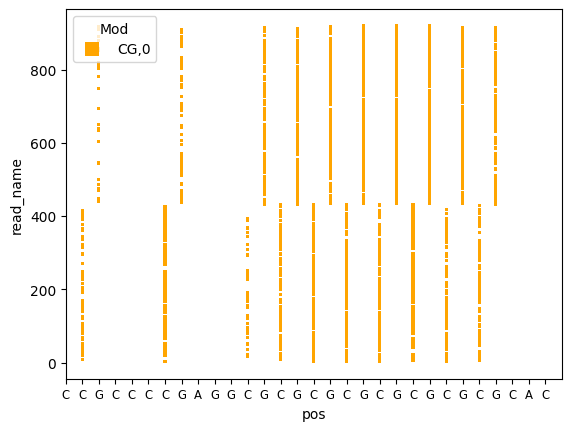

In [74]:
from matplotlib import pyplot as plt
from dimelo import plot_reads

fig, ax = plt.subplots()

ax = plot_reads.plot_reads(
    extract_file, # extracted_h5,
    regions = t2t_cd55_30bps, #'chr1:206582520-206585020',
    motifs = ['CG,0'],
    thresh = 0.75,
    sort_by = ['shuffle','strand'],
    # relative = False,
    relative = True,
    window_size = None, # 5000,
    s=5,
)
# plt.xlim(206582520,206585020)


seq = pysam.FastaFile(ref_genome_v1_1_file).fetch('chr1',206586162,206586192)
print(seq)
seq_list =  [s for s in seq]
plt.xticks(np.arange(len(seq_list)) - 15, seq_list, size='small')

CCGCCCCGAGGCGCGCGCGCGCGCGCGCAC


([<matplotlib.axis.XTick at 0x79c4160239d0>,
 [Text(-15, 0, 'C'),
  Text(-14, 0, 'C'),
  Text(-13, 0, 'G'),
  Text(-12, 0, 'C'),
  Text(-11, 0, 'C'),
  Text(-10, 0, 'C'),
  Text(-9, 0, 'C'),
  Text(-8, 0, 'G'),
  Text(-7, 0, 'A'),
  Text(-6, 0, 'G'),
  Text(-5, 0, 'G'),
  Text(-4, 0, 'C'),
  Text(-3, 0, 'G'),
  Text(-2, 0, 'C'),
  Text(-1, 0, 'G'),
  Text(0, 0, 'C'),
  Text(1, 0, 'G'),
  Text(2, 0, 'C'),
  Text(3, 0, 'G'),
  Text(4, 0, 'C'),
  Text(5, 0, 'G'),
  Text(6, 0, 'C'),
  Text(7, 0, 'G'),
  Text(8, 0, 'C'),
  Text(9, 0, 'G'),
  Text(10, 0, 'C'),
  Text(11, 0, 'G'),
  Text(12, 0, 'C'),
  Text(13, 0, 'A'),
  Text(14, 0, 'C')])

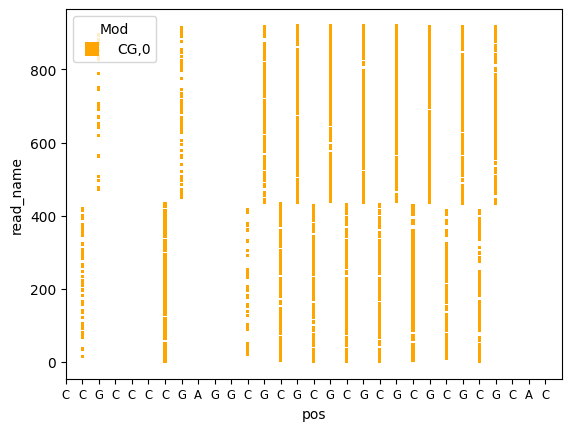

In [75]:
from matplotlib import pyplot as plt
from dimelo import plot_reads

fig, ax = plt.subplots()

ax = plot_reads.plot_reads(
    extract_file, # extracted_h5,
    regions = t2t_cd55_30bps, #'chr1:206582520-206585020',
    motifs = ['CG,0'],
    thresh = 0.75,
    sort_by = ['shuffle', 'strand'], # 'region_start'], # 'strand'], # 'shuffle',
    # relative = False,
    relative = True,
    window_size = None, # 5000,
    s=5,
)
# plt.xlim(206582520,206585020)


seq = pysam.FastaFile(ref_genome_v1_1_file).fetch('chr1',206586162,206586192)
print(seq)
seq_list =  [s for s in seq]
plt.xticks(np.arange(len(seq_list)) - 15, seq_list, size='small')

CCGCCCCGAGGCGCGCGCGCGCGCGCGCAC


([<matplotlib.axis.XTick at 0x79c415b00190>,
 [Text(-15, 0, 'C'),
  Text(-14, 0, 'C'),
  Text(-13, 0, 'G'),
  Text(-12, 0, 'C'),
  Text(-11, 0, 'C'),
  Text(-10, 0, 'C'),
  Text(-9, 0, 'C'),
  Text(-8, 0, 'G'),
  Text(-7, 0, 'A'),
  Text(-6, 0, 'G'),
  Text(-5, 0, 'G'),
  Text(-4, 0, 'C'),
  Text(-3, 0, 'G'),
  Text(-2, 0, 'C'),
  Text(-1, 0, 'G'),
  Text(0, 0, 'C'),
  Text(1, 0, 'G'),
  Text(2, 0, 'C'),
  Text(3, 0, 'G'),
  Text(4, 0, 'C'),
  Text(5, 0, 'G'),
  Text(6, 0, 'C'),
  Text(7, 0, 'G'),
  Text(8, 0, 'C'),
  Text(9, 0, 'G'),
  Text(10, 0, 'C'),
  Text(11, 0, 'G'),
  Text(12, 0, 'C'),
  Text(13, 0, 'A'),
  Text(14, 0, 'C')])

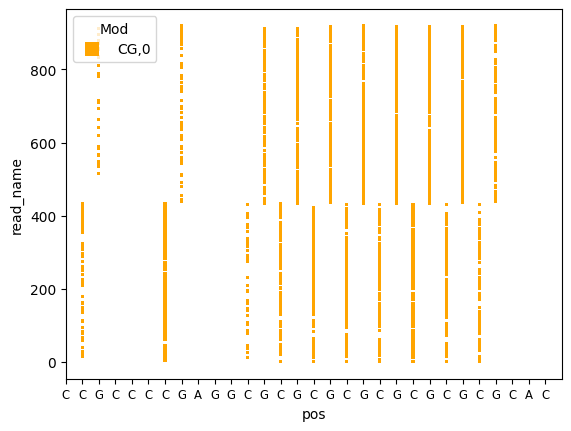

In [76]:
 from matplotlib import pyplot as plt
from dimelo import plot_reads

fig, ax = plt.subplots()

ax = plot_reads.plot_reads(
    extract_file, # extracted_h5,
    regions = t2t_cd55_30bps, #'chr1:206582520-206585020',
    motifs = ['CG,0'],
    thresh = 0.75,
    sort_by = ['shuffle', 'strand', 'region_start'], # 'strand'], # 'shuffle',
    # relative = False,
    relative = True,
    window_size = None, # 5000,
    s=5,
)
# plt.xlim(206582520,206585020)


seq = pysam.FastaFile(ref_genome_v1_1_file).fetch('chr1',206586162,206586192)
print(seq)
seq_list =  [s for s in seq]
plt.xticks(np.arange(len(seq_list)) - 15, seq_list, size='small')

CCGCCCCGAGGCGCGCGCGCGCGCGCGCAC


([<matplotlib.axis.XTick at 0x79c415ba7700>,
 [Text(-15, 0, 'C'),
  Text(-14, 0, 'C'),
  Text(-13, 0, 'G'),
  Text(-12, 0, 'C'),
  Text(-11, 0, 'C'),
  Text(-10, 0, 'C'),
  Text(-9, 0, 'C'),
  Text(-8, 0, 'G'),
  Text(-7, 0, 'A'),
  Text(-6, 0, 'G'),
  Text(-5, 0, 'G'),
  Text(-4, 0, 'C'),
  Text(-3, 0, 'G'),
  Text(-2, 0, 'C'),
  Text(-1, 0, 'G'),
  Text(0, 0, 'C'),
  Text(1, 0, 'G'),
  Text(2, 0, 'C'),
  Text(3, 0, 'G'),
  Text(4, 0, 'C'),
  Text(5, 0, 'G'),
  Text(6, 0, 'C'),
  Text(7, 0, 'G'),
  Text(8, 0, 'C'),
  Text(9, 0, 'G'),
  Text(10, 0, 'C'),
  Text(11, 0, 'G'),
  Text(12, 0, 'C'),
  Text(13, 0, 'A'),
  Text(14, 0, 'C')])

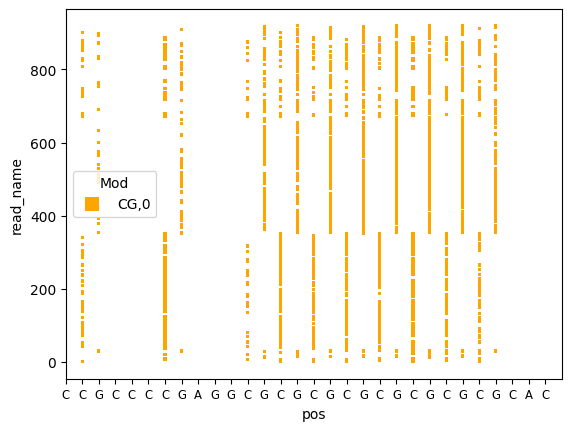

In [77]:
from matplotlib import pyplot as plt
from dimelo import plot_reads

fig, ax = plt.subplots()

ax = plot_reads.plot_reads(
    extract_file, # extracted_h5,
    regions = t2t_cd55_30bps, #'chr1:206582520-206585020',
    motifs = ['CG,0'],
    thresh = 0.75,
    sort_by = ['region_start'], # 'strand'], # 'shuffle',
    # relative = False,
    relative = True,
    window_size = None, # 5000,
    s=5,
)
# plt.xlim(206582520,206585020)


seq = pysam.FastaFile(ref_genome_v1_1_file).fetch('chr1',206586162,206586192)
print(seq)
seq_list =  [s for s in seq]
plt.xticks(np.arange(len(seq_list)) - 15, seq_list, size='small')

CCGCCCCGAGGCGCGCGCGCGCGCGCGCAC


([<matplotlib.axis.XTick at 0x79c415a08790>,
 [Text(-15, 0, 'C'),
  Text(-14, 0, 'C'),
  Text(-13, 0, 'G'),
  Text(-12, 0, 'C'),
  Text(-11, 0, 'C'),
  Text(-10, 0, 'C'),
  Text(-9, 0, 'C'),
  Text(-8, 0, 'G'),
  Text(-7, 0, 'A'),
  Text(-6, 0, 'G'),
  Text(-5, 0, 'G'),
  Text(-4, 0, 'C'),
  Text(-3, 0, 'G'),
  Text(-2, 0, 'C'),
  Text(-1, 0, 'G'),
  Text(0, 0, 'C'),
  Text(1, 0, 'G'),
  Text(2, 0, 'C'),
  Text(3, 0, 'G'),
  Text(4, 0, 'C'),
  Text(5, 0, 'G'),
  Text(6, 0, 'C'),
  Text(7, 0, 'G'),
  Text(8, 0, 'C'),
  Text(9, 0, 'G'),
  Text(10, 0, 'C'),
  Text(11, 0, 'G'),
  Text(12, 0, 'C'),
  Text(13, 0, 'A'),
  Text(14, 0, 'C')])

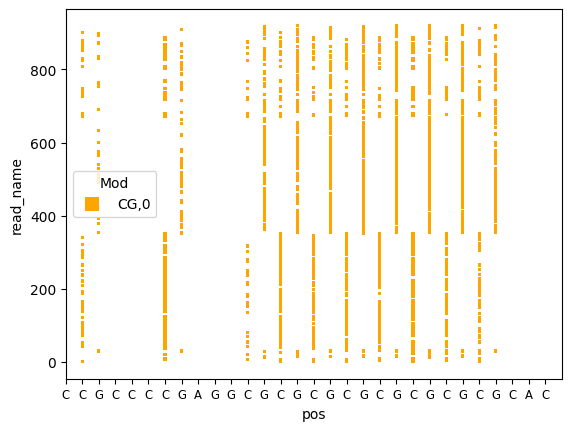

In [78]:
from matplotlib import pyplot as plt
from dimelo import plot_reads

fig, ax = plt.subplots()

ax = plot_reads.plot_reads(
    extract_file, # extracted_h5,
    regions = t2t_cd55_30bps, #'chr1:206582520-206585020',
    motifs = ['CG,0'],
    thresh = 0.75,
    sort_by = ['region_end'], # 'strand'], # 'shuffle',
    # relative = False,
    relative = True,
    window_size = None, # 5000,
    s=5,
)
# plt.xlim(206582520,206585020)


seq = pysam.FastaFile(ref_genome_v1_1_file).fetch('chr1',206586162,206586192)
print(seq)
seq_list =  [s for s in seq]
plt.xticks(np.arange(len(seq_list)) - 15, seq_list, size='small')

CCGCCCCGAGGCGCGCGCGCGCGCGCGCAC


([<matplotlib.axis.XTick at 0x79c415e462c0>,
 [Text(-15, 0, 'C'),
  Text(-14, 0, 'C'),
  Text(-13, 0, 'G'),
  Text(-12, 0, 'C'),
  Text(-11, 0, 'C'),
  Text(-10, 0, 'C'),
  Text(-9, 0, 'C'),
  Text(-8, 0, 'G'),
  Text(-7, 0, 'A'),
  Text(-6, 0, 'G'),
  Text(-5, 0, 'G'),
  Text(-4, 0, 'C'),
  Text(-3, 0, 'G'),
  Text(-2, 0, 'C'),
  Text(-1, 0, 'G'),
  Text(0, 0, 'C'),
  Text(1, 0, 'G'),
  Text(2, 0, 'C'),
  Text(3, 0, 'G'),
  Text(4, 0, 'C'),
  Text(5, 0, 'G'),
  Text(6, 0, 'C'),
  Text(7, 0, 'G'),
  Text(8, 0, 'C'),
  Text(9, 0, 'G'),
  Text(10, 0, 'C'),
  Text(11, 0, 'G'),
  Text(12, 0, 'C'),
  Text(13, 0, 'A'),
  Text(14, 0, 'C')])

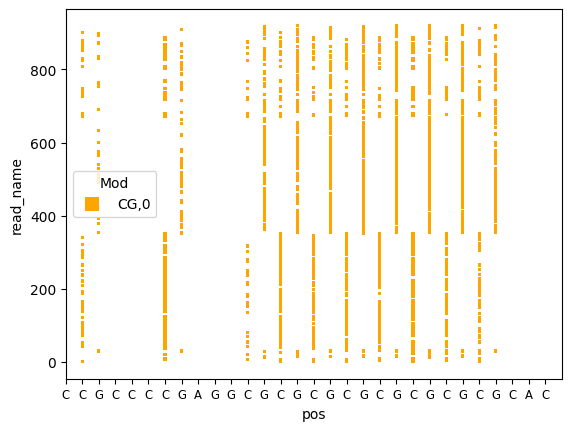

In [79]:
from matplotlib import pyplot as plt
from dimelo import plot_reads

fig, ax = plt.subplots()

ax = plot_reads.plot_reads(
    extract_file, # extracted_h5,
    regions = t2t_cd55_30bps, #'chr1:206582520-206585020',
    motifs = ['CG,0'],
    thresh = 0.75,
    sort_by = ['region_end','region_start' ], # 'strand'], # 'shuffle',
    # relative = False,
    relative = True,
    window_size = None, # 5000,
    s=5,
)
# plt.xlim(206582520,206585020)


seq = pysam.FastaFile(ref_genome_v1_1_file).fetch('chr1',206586162,206586192)
print(seq)
seq_list =  [s for s in seq]
plt.xticks(np.arange(len(seq_list)) - 15, seq_list, size='small')

In [80]:
np.arange(len(seq_list)) - 15

array([-15, -14, -13, -12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,
        -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
        11,  12,  13,  14])

In [81]:
extract_file

PosixPath('/content/drive/MyDrive/Michal Rozenwald/data/CD55/cas9_12ef_101923_misha/dimelo_new_package/cas9_12ef_101923_extract_30bps_chr1_206586162_206586192_wsNone_thresh190/reads.combined_basemods.h5')

In [82]:
from pathlib import Path

import pandas as pd
import seaborn as sns
from matplotlib.axes import Axes
import matplotlib.pyplot as plt

# from . import load_processed
# from . import utils

reads,read_names,mods,regions_dict = load_processed.readwise_binary_modification_arrays(
    extract_file, # extract_file_no_thresh, # raw modification probabilities
  regions=t2t_cd55_30bps, # cd55_30bps_interest_coords, # ctcf_target_regions,
  motifs=['CG,0'], # 'A,0'],
    sort_by = ['strand'], # 'shuffle',
    window_size=None,

)
      # file = mod_file_name,
      # regions = regions,
      # motifs = motifs,
      # window_size = window_size,
      # thresh = thresh,
      # relative = relative,
      # sort_by = sort_by,
    # )
  # match mod_file_name.suffix:
  #     case _:
  #         reads, read_names, mods = load_processed.reads_from_hdf5(
  #             file=mod_file_name,
#             bed_file=bed_file_name,
  #             mod_names=mod_names,
  #             window_size=window_size,
  #         )

# Convert data frame where each row represents a read to a data frame where each row represents a single modified position in a read
df = pd.DataFrame({
    'read_name': read_names,
    'mod': mods,
    'pos': reads
}).explode('pos')

In [83]:
df

read_name   mod  pos
0             0  CG,0   -2
1             0  CG,0    0
2             0  CG,0    2
3             0  CG,0    6
4             0  CG,0   10
...         ...   ...  ...
2400        919  CG,0   -1
2401        919  CG,0    5
2402        919  CG,0    7
2403        919  CG,0    9
2404        919  CG,0   11

[2405 rows x 3 columns]

In [84]:
df

read_name   mod  pos
0             0  CG,0   -2
1             0  CG,0    0
2             0  CG,0    2
3             0  CG,0    6
4             0  CG,0   10
...         ...   ...  ...
2400        919  CG,0   -1
2401        919  CG,0    5
2402        919  CG,0    7
2403        919  CG,0    9
2404        919  CG,0   11

[2405 rows x 3 columns]

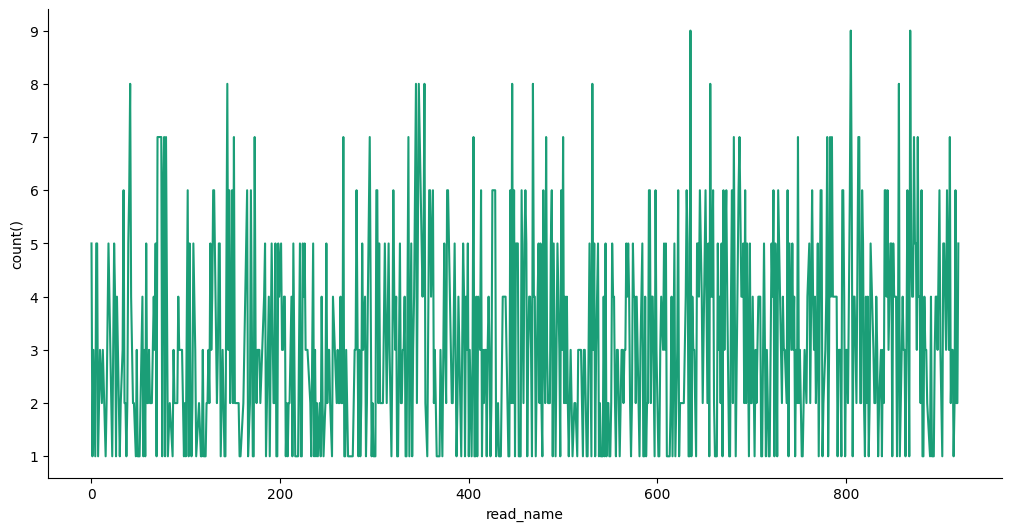

In [85]:
# @title read_name vs count()

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['read_name']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'read_name'}, axis=1)
              .sort_values('read_name', ascending=True))
  xs = counted['read_name']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('read_name', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('read_name')
_ = plt.ylabel('count()')

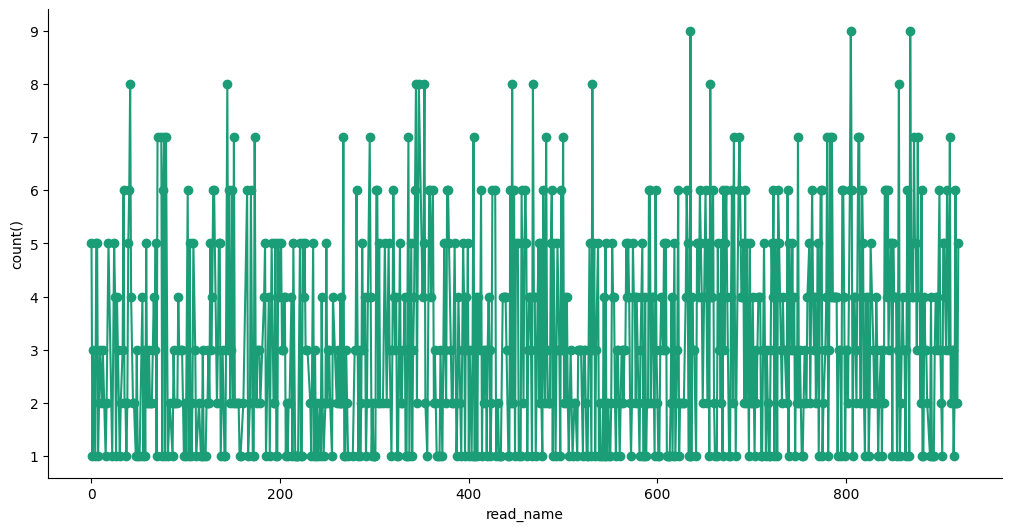

In [86]:
# @title read_name vs count()

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['read_name']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'read_name'}, axis=1)
              .sort_values('read_name', ascending=True))
  xs = counted['read_name']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)], marker='o' )

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('read_name', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('read_name')
_ = plt.ylabel('count()')

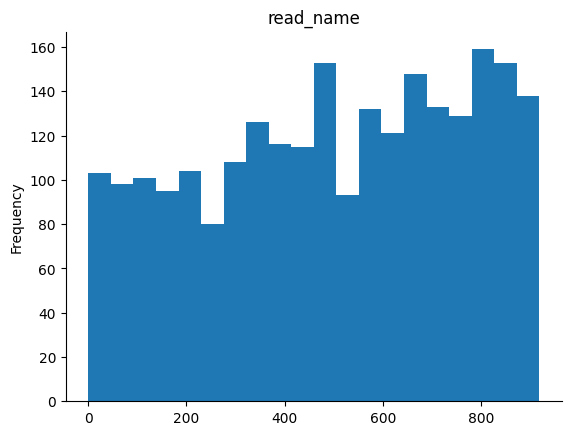

In [87]:
# @title read_name

from matplotlib import pyplot as plt
df['read_name'].plot(kind='hist', bins=20, title='read_name')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [88]:
len(np.unique(df['read_name']))

766

In [89]:
all_reads = np.unique(df['read_name'])
all_reads

array([  0,   1,   2,   4,   5,   6,   7,   8,   9,  11,  12,  15,  16,
        18,  22,  24,  25,  26,  27,  28,  30,  31,  33,  34,  35,  36,
        37,  38,  39,  40,  41,  42,  44,  45,  47,  48,  49,  51,  54,
        55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
        68,  69,  70,  74,  75,  76,  77,  78,  79,  81,  83,  86,  87,
        88,  89,  91,  92,  93,  95,  96,  98,  99, 100, 102, 103, 104,
       105, 106, 107, 108, 110, 111, 114, 116, 117, 118, 119, 121, 122,
       123, 124, 125, 126, 127, 128, 129, 130, 133, 134, 135, 136, 137,
       139, 141, 142, 144, 145, 146, 147, 148, 149, 150, 151, 152, 154,
       155, 156, 157, 158, 161, 165, 166, 168, 169, 171, 172, 173, 174,
       175, 176, 178, 179, 183, 184, 185, 188, 189, 191, 193, 194, 195,
       196, 197, 198, 199, 201, 202, 203, 204, 205, 206, 207, 208, 209,
       210, 212, 213, 214, 216, 217, 218, 219, 221, 222, 223, 224, 225,
       226, 227, 229, 232, 233, 235, 236, 237, 238, 239, 240, 24

In [90]:
df['pos_shifted'] = df['pos'] + 15
df

read_name   mod  pos  pos_shifted
0             0  CG,0   -2           13
1             0  CG,0    0           15
2             0  CG,0    2           17
3             0  CG,0    6           21
4             0  CG,0   10           25
...         ...   ...  ...          ...
2400        919  CG,0   -1           14
2401        919  CG,0    5           20
2402        919  CG,0    7           22
2403        919  CG,0    9           24
2404        919  CG,0   11           26

[2405 rows x 4 columns]

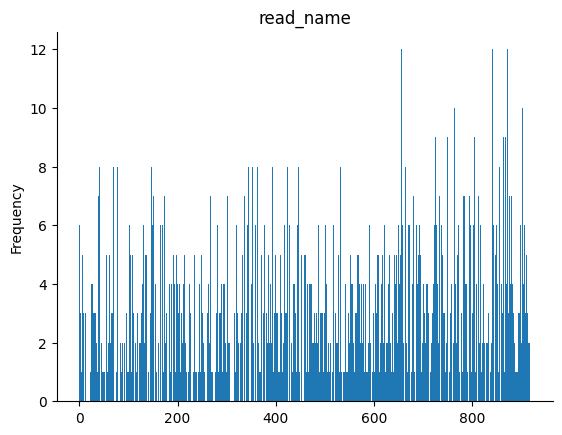

In [91]:
# @title read_name

from matplotlib import pyplot as plt
df['read_name'].plot(kind='hist', bins=800, title='read_name')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [92]:
len(np.unique(df.read_name))

766

# Qs: <!> 766 not 920 -> why?

In [93]:
df[df["read_name"] == 0]

read_name   mod  pos  pos_shifted
0          0  CG,0   -2           13
1          0  CG,0    0           15
2          0  CG,0    2           17
3          0  CG,0    6           21
4          0  CG,0   10           25

In [94]:
df[df["read_name"] == 16]

read_name   mod  pos  pos_shifted
32         16  CG,0    6           21
33         16  CG,0   10           25

In [95]:
df[df["read_name"] == 160]

Empty DataFrame
Columns: [read_name, mod, pos, pos_shifted]
Index: []

# > empty values for other positions?
> fill in the empy values?

In [96]:
# df.groupby(['read_name']['pos']).mean()

In [97]:
(df.groupby(['read_name'])).head()#.mean()

read_name   mod  pos  pos_shifted
0             0  CG,0   -2           13
1             0  CG,0    0           15
2             0  CG,0    2           17
3             0  CG,0    6           21
4             0  CG,0   10           25
...         ...   ...  ...          ...
2400        919  CG,0   -1           14
2401        919  CG,0    5           20
2402        919  CG,0    7           22
2403        919  CG,0    9           24
2404        919  CG,0   11           26

[2255 rows x 4 columns]

In [98]:
df

read_name   mod  pos  pos_shifted
0             0  CG,0   -2           13
1             0  CG,0    0           15
2             0  CG,0    2           17
3             0  CG,0    6           21
4             0  CG,0   10           25
...         ...   ...  ...          ...
2400        919  CG,0   -1           14
2401        919  CG,0    5           20
2402        919  CG,0    7           22
2403        919  CG,0    9           24
2404        919  CG,0   11           26

[2405 rows x 4 columns]

<ipython-input-99-1436c324b5ac>:29: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


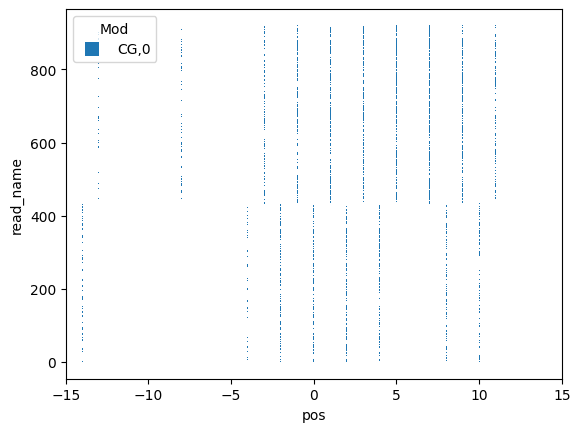

In [99]:
# Link to function https://github.com/streetslab/dimelo/blob/modkit_parsing_beta/dimelo/plot_reads.py#L56C1-L79C22

# mod_file_name = Path(mod_file_name)
# bed_file_name = Path(bed_file_name)
size = 0.5 # kwargs.pop('s', 0.5)

# palette = kwargs.pop('palette', {})

# merged_palette = {**utils.DEFAULT_COLORS, **palette}

axes = sns.scatterplot(
    data=df,
    x="pos",
    y="read_name",
    hue="mod",
    # palette=colors,
    s=size,
    marker="s",
    linewidth=0,
    # palette = merged_palette,
    # **kwargs
)
# Retrieve the existing legend
legend = axes.legend_

# Update legend properties
if legend is not None:
    legend.set_title('Mod')
    for handle in legend.legendHandles:
        handle.set_markersize(10)  # Set a larger marker size for legend

relative = True
if relative:
    region1_start,region1_end,_ = next(iter(regions_dict.values()))[0]
    effective_window_size = (region1_end-region1_start)//2
    axes.set_xlim([-effective_window_size,effective_window_size])

# return axes

In [100]:
extract_file

PosixPath('/content/drive/MyDrive/Michal Rozenwald/data/CD55/cas9_12ef_101923_misha/dimelo_new_package/cas9_12ef_101923_extract_30bps_chr1_206586162_206586192_wsNone_thresh190/reads.combined_basemods.h5')

In [101]:
extract_file

PosixPath('/content/drive/MyDrive/Michal Rozenwald/data/CD55/cas9_12ef_101923_misha/dimelo_new_package/cas9_12ef_101923_extract_30bps_chr1_206586162_206586192_wsNone_thresh190/reads.combined_basemods.h5')

In [102]:

reads,read_names,mods,regions_dict = load_processed.readwise_binary_modification_arrays(
    extract_file, # extract_file_no_thresh, # raw modification probabilities
    regions=t2t_cd55_30bps, # cd55_30bps_interest_coords, # ctcf_target_regions,
    motifs=['CG,0'], # 'A,0'],
    relative = False,
    # window_size = None, # window_size,
)
      # file = mod_file_name,
      # regions = regions,
      # motifs = motifs,
      # window_size = window_size,
      # thresh = thresh,
      # relative = relative,
      # sort_by = sort_by,
  # )
  # match mod_file_name.suffix:
  #     case _:
  #         reads, read_names, mods = load_processed.reads_from_hdf5(
  #             file=mod_file_name,
#             bed_file=bed_file_name,
  #             mod_names=mod_names,
  #             window_size=window_size,
  #         )

# Convert data frame where each row represents a read to a data frame where each row represents a single modified position in a read
df_with_coords = pd.DataFrame({
    'read_name': read_names,
    'mod': mods,
    'pos': reads
}).explode('pos')

In [103]:
len(np.unique(df_with_coords.read_name))

766

In [104]:
df_with_coords

read_name   mod        pos
0             0  CG,0  206586175
1             0  CG,0  206586177
2             0  CG,0  206586179
3             0  CG,0  206586183
4             0  CG,0  206586187
...         ...   ...        ...
2400        919  CG,0  206586176
2401        919  CG,0  206586182
2402        919  CG,0  206586184
2403        919  CG,0  206586186
2404        919  CG,0  206586188

[2405 rows x 3 columns]

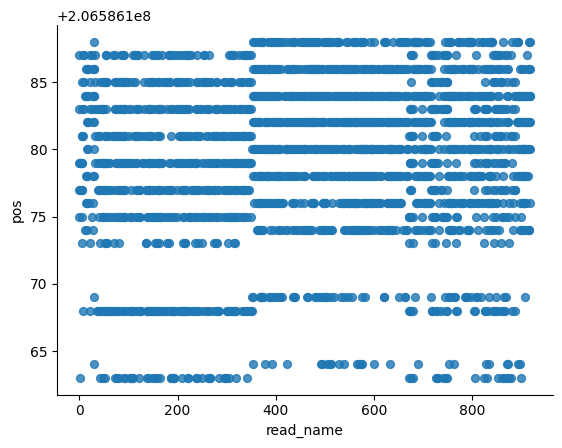

In [105]:
# @title read_name vs pos

from matplotlib import pyplot as plt
df_with_coords.plot(kind='scatter', x='read_name', y='pos', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

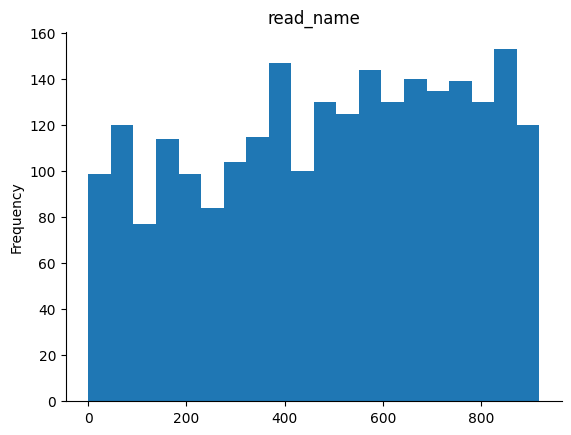

In [106]:
# @title read_name

from matplotlib import pyplot as plt
df_with_coords['read_name'].plot(kind='hist', bins=20, title='read_name')
plt.gca().spines[['top', 'right',]].set_visible(False)

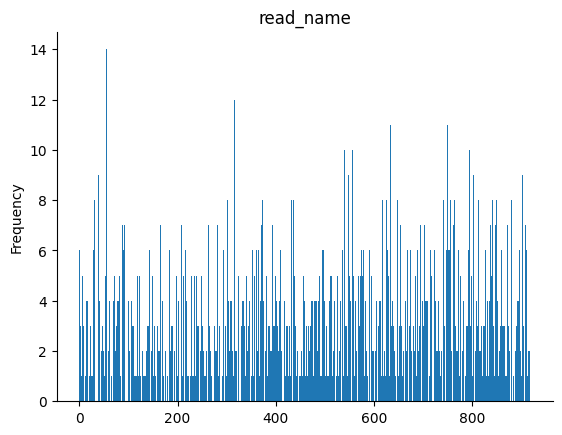

In [107]:
# @title read_name

from matplotlib import pyplot as plt
df_with_coords['read_name'].plot(kind='hist', bins=800, title='read_name')
plt.gca().spines[['top', 'right',]].set_visible(False)

# Extract the mC vectors for each read




In [108]:
df

read_name   mod  pos  pos_shifted
0             0  CG,0   -2           13
1             0  CG,0    0           15
2             0  CG,0    2           17
3             0  CG,0    6           21
4             0  CG,0   10           25
...         ...   ...  ...          ...
2400        919  CG,0   -1           14
2401        919  CG,0    5           20
2402        919  CG,0    7           22
2403        919  CG,0    9           24
2404        919  CG,0   11           26

[2405 rows x 4 columns]

In [109]:
df['read_name']

0         0
1         0
2         0
3         0
4         0
       ... 
2400    919
2401    919
2402    919
2403    919
2404    919
Name: read_name, Length: 2405, dtype: int64

In [110]:
# for df
df

read_name   mod  pos  pos_shifted
0             0  CG,0   -2           13
1             0  CG,0    0           15
2             0  CG,0    2           17
3             0  CG,0    6           21
4             0  CG,0   10           25
...         ...   ...  ...          ...
2400        919  CG,0   -1           14
2401        919  CG,0    5           20
2402        919  CG,0    7           22
2403        919  CG,0    9           24
2404        919  CG,0   11           26

[2405 rows x 4 columns]

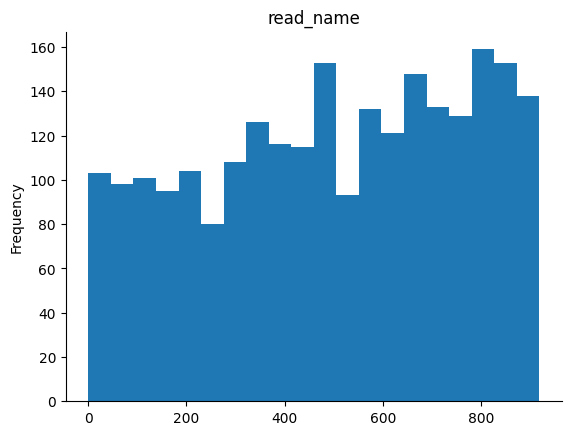

In [111]:
# @title read_name

from matplotlib import pyplot as plt
df['read_name'].plot(kind='hist', bins=20, title='read_name')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [112]:
df.groupby("read_name").count() #["pos"].count()

mod  pos  pos_shifted
read_name                       
0            5    5            5
1            1    1            1
2            3    3            3
4            1    1            1
5            5    5            5
...        ...  ...          ...
915          2    2            2
916          6    6            6
917          2    2            2
918          2    2            2
919          5    5            5

[766 rows x 3 columns]

In [113]:
len(read_names)

2405

In [114]:
read_names_unique = np.unique(df['read_name'])
num_reads = len(read_names_unique)
num_reads

766

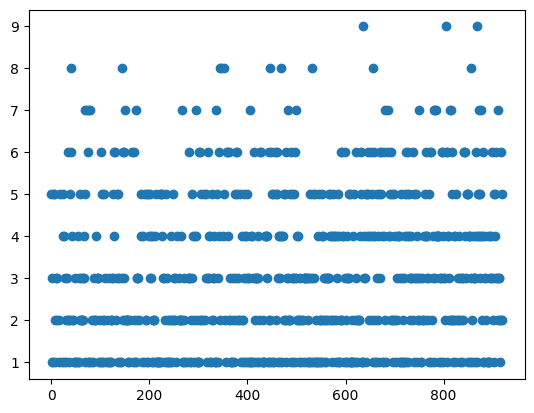

In [115]:
plt.scatter(read_names_unique, df.groupby("read_name")["pos"].count()) #)

(array([185., 153., 133., 110.,   0.,  87.,  62.,  23.,  10.,   3.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <BarContainer object of 10 artists>)

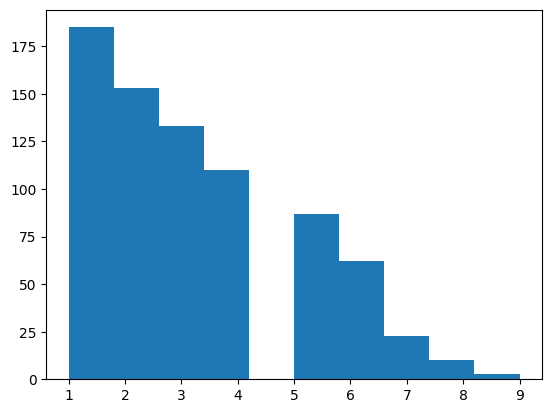

In [116]:
plt.hist(df.groupby("read_name")["pos"].count()) #)

In [117]:
seq

'CCGCCCCGAGGCGCGCGCGCGCGCGCGCAC'

In [118]:
len(seq.split("CG"))

11

In [119]:
num_reads

766

In [120]:
reads_dict_nums = dict(enumerate(read_names_unique))
reads_dict_nums

{0: 0,
 1: 1,
 2: 2,
 3: 4,
 4: 5,
 5: 6,
 6: 7,
 7: 8,
 8: 9,
 9: 11,
 10: 12,
 11: 15,
 12: 16,
 13: 18,
 14: 22,
 15: 24,
 16: 25,
 17: 26,
 18: 27,
 19: 28,
 20: 30,
 21: 31,
 22: 33,
 23: 34,
 24: 35,
 25: 36,
 26: 37,
 27: 38,
 28: 39,
 29: 40,
 30: 41,
 31: 42,
 32: 44,
 33: 45,
 34: 47,
 35: 48,
 36: 49,
 37: 51,
 38: 54,
 39: 55,
 40: 56,
 41: 57,
 42: 58,
 43: 59,
 44: 60,
 45: 61,
 46: 62,
 47: 63,
 48: 64,
 49: 65,
 50: 66,
 51: 67,
 52: 68,
 53: 69,
 54: 70,
 55: 74,
 56: 75,
 57: 76,
 58: 77,
 59: 78,
 60: 79,
 61: 81,
 62: 83,
 63: 86,
 64: 87,
 65: 88,
 66: 89,
 67: 91,
 68: 92,
 69: 93,
 70: 95,
 71: 96,
 72: 98,
 73: 99,
 74: 100,
 75: 102,
 76: 103,
 77: 104,
 78: 105,
 79: 106,
 80: 107,
 81: 108,
 82: 110,
 83: 111,
 84: 114,
 85: 116,
 86: 117,
 87: 118,
 88: 119,
 89: 121,
 90: 122,
 91: 123,
 92: 124,
 93: 125,
 94: 126,
 95: 127,
 96: 128,
 97: 129,
 98: 130,
 99: 133,
 100: 134,
 101: 135,
 102: 136,
 103: 137,
 104: 139,
 105: 141,
 106: 142,
 107: 144,
 108:

In [121]:
reads_dict = dict()

for i in range(len(read_names_unique)):
  reads_dict[read_names_unique[i]] = i
reads_dict

{0: 0,
 1: 1,
 2: 2,
 4: 3,
 5: 4,
 6: 5,
 7: 6,
 8: 7,
 9: 8,
 11: 9,
 12: 10,
 15: 11,
 16: 12,
 18: 13,
 22: 14,
 24: 15,
 25: 16,
 26: 17,
 27: 18,
 28: 19,
 30: 20,
 31: 21,
 33: 22,
 34: 23,
 35: 24,
 36: 25,
 37: 26,
 38: 27,
 39: 28,
 40: 29,
 41: 30,
 42: 31,
 44: 32,
 45: 33,
 47: 34,
 48: 35,
 49: 36,
 51: 37,
 54: 38,
 55: 39,
 56: 40,
 57: 41,
 58: 42,
 59: 43,
 60: 44,
 61: 45,
 62: 46,
 63: 47,
 64: 48,
 65: 49,
 66: 50,
 67: 51,
 68: 52,
 69: 53,
 70: 54,
 74: 55,
 75: 56,
 76: 57,
 77: 58,
 78: 59,
 79: 60,
 81: 61,
 83: 62,
 86: 63,
 87: 64,
 88: 65,
 89: 66,
 91: 67,
 92: 68,
 93: 69,
 95: 70,
 96: 71,
 98: 72,
 99: 73,
 100: 74,
 102: 75,
 103: 76,
 104: 77,
 105: 78,
 106: 79,
 107: 80,
 108: 81,
 110: 82,
 111: 83,
 114: 84,
 116: 85,
 117: 86,
 118: 87,
 119: 88,
 121: 89,
 122: 90,
 123: 91,
 124: 92,
 125: 93,
 126: 94,
 127: 95,
 128: 96,
 129: 97,
 130: 98,
 133: 99,
 134: 100,
 135: 101,
 136: 102,
 137: 103,
 139: 104,
 141: 105,
 142: 106,
 144: 107,
 145:

# <!!!!> Build padded reads <!!!!>

In [122]:
padded_reads = np.zeros([num_reads, 30])
padded_reads

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [153]:
padded_reads.shape

(766, 30)

# SWITCH TO Nans -> to distriguish empty values from unmethylated

In [155]:
padded_reads = padded_reads + np.nan
padded_reads.shape, padded_reads

((766, 30),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]))

In [159]:
i=16
df['read_name'][i]#, df['pos_shifted'][i]]

6

In [160]:
i=1
padded_reads[reads_dict[df['read_name'][i]], df['pos_shifted'][i]]

nan

In [161]:
for i in range(len(df['read_name'])):
  # df['pos_shifted']:
  padded_reads[reads_dict[df['read_name'][i]], df['pos_shifted'][i]] = 1
padded_reads

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan,  1., nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [162]:
padded_reads[0]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        1., nan,  1., nan,  1., nan, nan, nan,  1., nan, nan, nan,  1.,
       nan, nan, nan, nan])

In [163]:
df[df["read_name"] == 0]

read_name   mod  pos  pos_shifted
0          0  CG,0   -2           13
1          0  CG,0    0           15
2          0  CG,0    2           17
3          0  CG,0    6           21
4          0  CG,0   10           25

In [164]:
padded_reads

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan,  1., nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

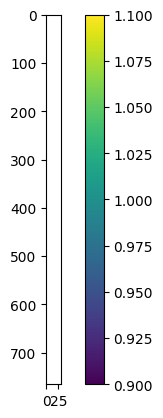

In [165]:
plt.imshow(padded_reads) # np.random.random((50,50)))
plt.colorbar()
plt.show()

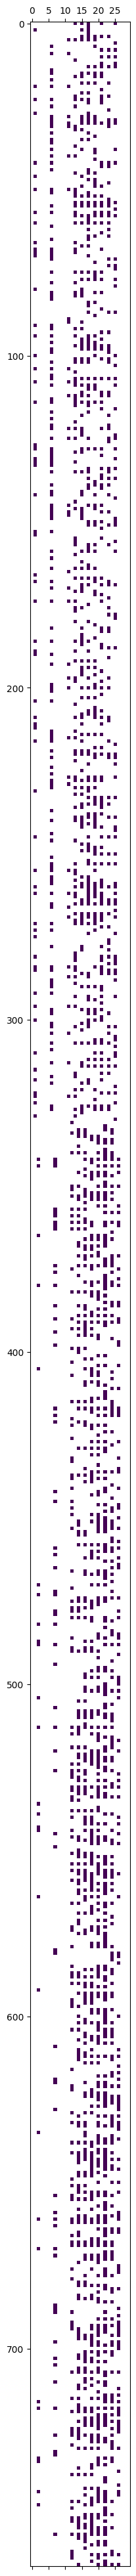

In [166]:
plt.figure(figsize=(10,50))
plt.matshow(padded_reads, fignum=1)


In [173]:
padded_reads_df = pd.DataFrame(padded_reads)
padded_reads_df

0    1   2   3   4   5   6   7   8   9   ...   20   21   22   23   24  \
0   NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN  1.0  NaN  NaN  NaN   
1   NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN  NaN  NaN  NaN  NaN   
2   NaN  1.0 NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN  NaN  NaN  NaN  NaN   
3   NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN  NaN  NaN  NaN  NaN   
4   NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN  1.0  NaN  1.0  NaN   
..   ..  ...  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...  ...  ...   
761 NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN  NaN  NaN  NaN  1.0   
762 NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  1.0  NaN  1.0  NaN  1.0   
763 NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  1.0  NaN  NaN  NaN  NaN   
764 NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN  NaN  1.0  NaN  NaN   
765 NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  1.0  NaN  1.0  NaN  1.0   

      25   26  27  28  29  
0    1.0  NaN NaN NaN NaN  
1    NaN  NaN NaN NaN NaN  
2    NaN  NaN NaN NaN NaN  
3    NaN  NaN NaN NaN NaN  
4    NaN  NaN NaN NaN NaN  
..   ...  ...  ..  ..  ..  
761  NaN  NaN NaN NaN NaN  
762  NaN  1.0 NaN NaN NaN  
763  NaN  NaN NaN NaN NaN  
764  NaN  NaN NaN NaN NaN  
765  NaN  1.0 NaN NaN NaN  

[766 rows x 30 columns]

In [176]:
len(seq_list), seq_list

(30,
 ['C',
  'C',
  'G',
  'C',
  'C',
  'C',
  'C',
  'G',
  'A',
  'G',
  'G',
  'C',
  'G',
  'C',
  'G',
  'C',
  'G',
  'C',
  'G',
  'C',
  'G',
  'C',
  'G',
  'C',
  'G',
  'C',
  'G',
  'C',
  'A',
  'C'])

In [177]:
padded_reads_df.columns = seq_list
padded_reads_df

C    C   G   C   C   C   C   G   A   G  ...    G    C    G    C    G  \
0   NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN  1.0  NaN  NaN  NaN   
1   NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN  NaN  NaN  NaN  NaN   
2   NaN  1.0 NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN  NaN  NaN  NaN  NaN   
3   NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN  NaN  NaN  NaN  NaN   
4   NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN  1.0  NaN  1.0  NaN   
..   ..  ...  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...  ...  ...   
761 NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN  NaN  NaN  NaN  1.0   
762 NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  1.0  NaN  1.0  NaN  1.0   
763 NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  1.0  NaN  NaN  NaN  NaN   
764 NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN  NaN  1.0  NaN  NaN   
765 NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  1.0  NaN  1.0  NaN  1.0   

       C    G   C   A   C  
0    1.0  NaN NaN NaN NaN  
1    NaN  NaN NaN NaN NaN  
2    NaN  NaN NaN NaN NaN  
3    NaN  NaN NaN NaN NaN  
4    NaN  NaN NaN NaN NaN  
..   ...  ...  ..  ..  ..  
761  NaN  NaN NaN NaN NaN  
762  NaN  1.0 NaN NaN NaN  
763  NaN  NaN NaN NaN NaN  
764  NaN  NaN NaN NaN NaN  
765  NaN  1.0 NaN NaN NaN  

[766 rows x 30 columns]

In [178]:
padded_reads_df.describe()

C     C     G    C    C    C      C     G    A    G  ...      G  \
count  0.0  60.0  27.0  0.0  0.0  0.0  128.0  61.0  0.0  0.0  ...  211.0   
mean   NaN   1.0   1.0  NaN  NaN  NaN    1.0   1.0  NaN  NaN  ...    1.0   
std    NaN   0.0   0.0  NaN  NaN  NaN    0.0   0.0  NaN  NaN  ...    0.0   
min    NaN   1.0   1.0  NaN  NaN  NaN    1.0   1.0  NaN  NaN  ...    1.0   
25%    NaN   1.0   1.0  NaN  NaN  NaN    1.0   1.0  NaN  NaN  ...    1.0   
50%    NaN   1.0   1.0  NaN  NaN  NaN    1.0   1.0  NaN  NaN  ...    1.0   
75%    NaN   1.0   1.0  NaN  NaN  NaN    1.0   1.0  NaN  NaN  ...    1.0   
max    NaN   1.0   1.0  NaN  NaN  NaN    1.0   1.0  NaN  NaN  ...    1.0   

           C      G     C      G     C      G    C    A    C  
count  115.0  225.0  90.0  169.0  78.0  122.0  0.0  0.0  0.0  
mean     1.0    1.0   1.0    1.0   1.0    1.0  NaN  NaN  NaN  
std      0.0    0.0   0.0    0.0   0.0    0.0  NaN  NaN  NaN  
min      1.0    1.0   1.0    1.0   1.0    1.0  NaN  NaN  NaN  
25%      1.0    1.0   1.0    1.0   1.0    1.0  NaN  NaN  NaN  
50%      1.0    1.0   1.0    1.0   1.0    1.0  NaN  NaN  NaN  
75%      1.0    1.0   1.0    1.0   1.0    1.0  NaN  NaN  NaN  
max      1.0    1.0   1.0    1.0   1.0    1.0  NaN  NaN  NaN  

[8 rows x 30 columns]

# Save mC profiles np.ARRAY!

In [180]:
padded_reads.shape, padded_reads

((766, 30),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan,  1., nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]))

In [181]:
!pwd

/content/dimelo


In [182]:
save_folder_path = "/content/drive/MyDrive/Michal Rozenwald/data/CD55/dimelo/etracted_reads"
save_folder_path

'/content/drive/MyDrive/Michal Rozenwald/data/CD55/dimelo/etracted_reads'

In [185]:
# cd55_30pbRIO_padded_reads_24Apr16.npy
save_name_np = "cd55_30pbRIO_padded_reads_24Apr16.npy"
Path(save_folder_path, save_name_np)

PosixPath('/content/drive/MyDrive/Michal Rozenwald/data/CD55/dimelo/etracted_reads/cd55_30pbRIO_padded_reads_24Apr16.npy')

In [187]:
# cd55_30pbRIO_padded_reads_24Apr16.npy
save_name = "cd55_30pbRIO_padded_reads_24Apr16"
save_name_np = save_name + ".npy"

np.save(Path(save_folder_path, save_name_np), padded_reads)

In [189]:
save_name = "cd55_30pbRIO_padded_reads_24Apr16"
save_name_csv = save_name + ".csv"

padded_reads_df.to_csv(Path(save_folder_path, save_name_csv))

# TODO: [2024, Apr. 16]:
- repeat this mC arrays extraction for our other .bam files - start with GM12878 - deepest - 30 bps - deepCTCF that I have stored theoretically xD

- count how many compliteley empty reads at the whole ROI 30bps region (maybe they had some signal outside out ROI - which is why they passes the QC filters?)


- have a way to differenciate the lack of signal within the read and "outside" - meanin before/after the read beginning/end
- -  =>>> maybe store the start - end coords of a read - of at least if it's cutting inside my ROI?
- - add "-1" for the emply values that are "between" the first and last mC signal for each read? (this will alow me to avoid going back to extracting the full coordinates -> which is less clean and more short term, but at least identifies that the empty signal is INSIDE the actually sequenced READ???)

In [167]:
mC_frac = padded_reads.mean(axis=0)
mC_frac

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan])

CCGCCCCGAGGCGCGCGCGCGCGCGCGCAC


<ipython-input-168-c6f3b25ed6b8>:22: RuntimeWarning: invalid value encountered in divide
  pileup_frac = mod_counts_vector / val_counts_vector


([<matplotlib.axis.XTick at 0x79c415528940>,
 [Text(0, 0, 'C'),
  Text(1, 0, 'C'),
  Text(2, 0, 'G'),
  Text(3, 0, 'C'),
  Text(4, 0, 'C'),
  Text(5, 0, 'C'),
  Text(6, 0, 'C'),
  Text(7, 0, 'G'),
  Text(8, 0, 'A'),
  Text(9, 0, 'G'),
  Text(10, 0, 'G'),
  Text(11, 0, 'C'),
  Text(12, 0, 'G'),
  Text(13, 0, 'C'),
  Text(14, 0, 'G'),
  Text(15, 0, 'C'),
  Text(16, 0, 'G'),
  Text(17, 0, 'C'),
  Text(18, 0, 'G'),
  Text(19, 0, 'C'),
  Text(20, 0, 'G'),
  Text(21, 0, 'C'),
  Text(22, 0, 'G'),
  Text(23, 0, 'C'),
  Text(24, 0, 'G'),
  Text(25, 0, 'C'),
  Text(26, 0, 'G'),
  Text(27, 0, 'C'),
  Text(28, 0, 'A'),
  Text(29, 0, 'C')])

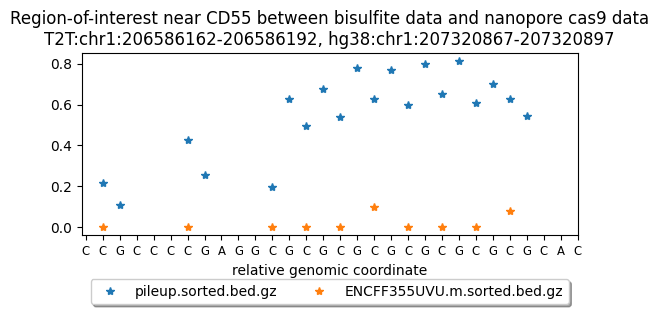

In [168]:
from matplotlib import pyplot as plt
t2t_cd55 = 'chr1:206586162-206586192'
hg38_cd55 = 'chr1:207320867-207320897'

# caspileup = '/Users/oberondixon-luinenburg/Documents/Ioannidis-Streets/dimelo_test_data/cd55_cas9/cd55_tss/pileup.sorted.bed.gz'
cas9_nanapore_bedgz = '/content/drive/MyDrive/Michal Rozenwald/data/CD55/cas9_12ef_101923_misha/dimelo_new_package/cd55_tss_pileup_ws4000/pileup.sorted.bed.gz' # pileup
T_bedgz = Path('/content/drive/MyDrive/Michal Rozenwald/data/ENCODE/T_primary_ENCSR663MXB/ENCFF355UVU.m.sorted.bed.gz') #'/Users/oberondixon-luinenburg/Downloads/ENCFF279HCL.m.sorted.bed.gz')

from dimelo import plot_enrichment_profile
from dimelo import load_processed
import pysam

fig, ax = plt.subplots()

for file,region in zip([cas9_nanapore_bedgz,T_bedgz],[t2t_cd55,hg38_cd55]):
    mod_counts_vector,val_counts_vector = load_processed.pileup_vectors_from_bedmethyl(
        bedmethyl_file = file,
        motif = 'CG,0',
        regions = region,
        window_size = None
    )
    pileup_frac = mod_counts_vector / val_counts_vector
    ax.plot(pileup_frac,'*',label=Path(file).name)

plt.title(f'Region-of-interest near CD55 between bisulfite data and nanopore cas9 data\nT2T:{t2t_cd55}, hg38:{hg38_cd55}')
plt.xlabel('relative genomic coordinate')
# plt.legend()
plt.subplots_adjust(bottom=0.5)  # Adjust the bottom
# Placing the legend at the bottom outside of the figure
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), shadow=True, ncol=2)

seq = pysam.FastaFile(ref_genome_v1_1_file).fetch('chr1',206586162,206586192)
print(seq)
seq_list =  [s for s in seq]
plt.xticks(range(len(seq_list)), seq_list, size='small')

CCGCCCCGAGGCGCGCGCGCGCGCGCGCAC


<ipython-input-169-7bd2d4d12ae4>:22: RuntimeWarning: invalid value encountered in divide
  pileup_frac = mod_counts_vector / val_counts_vector


([<matplotlib.axis.XTick at 0x79c415599060>,
 [Text(0, 0, 'C'),
  Text(1, 0, 'C'),
  Text(2, 0, 'G'),
  Text(3, 0, 'C'),
  Text(4, 0, 'C'),
  Text(5, 0, 'C'),
  Text(6, 0, 'C'),
  Text(7, 0, 'G'),
  Text(8, 0, 'A'),
  Text(9, 0, 'G'),
  Text(10, 0, 'G'),
  Text(11, 0, 'C'),
  Text(12, 0, 'G'),
  Text(13, 0, 'C'),
  Text(14, 0, 'G'),
  Text(15, 0, 'C'),
  Text(16, 0, 'G'),
  Text(17, 0, 'C'),
  Text(18, 0, 'G'),
  Text(19, 0, 'C'),
  Text(20, 0, 'G'),
  Text(21, 0, 'C'),
  Text(22, 0, 'G'),
  Text(23, 0, 'C'),
  Text(24, 0, 'G'),
  Text(25, 0, 'C'),
  Text(26, 0, 'G'),
  Text(27, 0, 'C'),
  Text(28, 0, 'A'),
  Text(29, 0, 'C')])

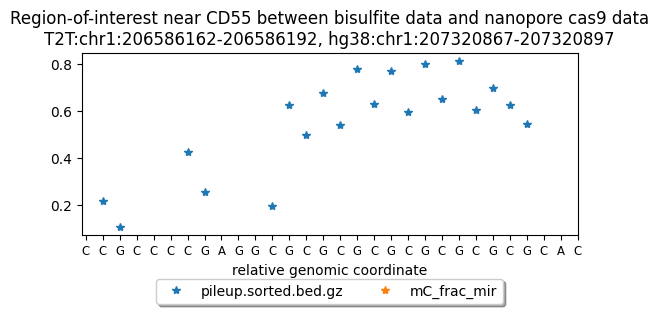

In [169]:
from matplotlib import pyplot as plt
t2t_cd55 = 'chr1:206586162-206586192'
hg38_cd55 = 'chr1:207320867-207320897'

# caspileup = '/Users/oberondixon-luinenburg/Documents/Ioannidis-Streets/dimelo_test_data/cd55_cas9/cd55_tss/pileup.sorted.bed.gz'
cas9_nanapore_bedgz = '/content/drive/MyDrive/Michal Rozenwald/data/CD55/cas9_12ef_101923_misha/dimelo_new_package/cd55_tss_pileup_ws4000/pileup.sorted.bed.gz' # pileup
T_bedgz = Path('/content/drive/MyDrive/Michal Rozenwald/data/ENCODE/T_primary_ENCSR663MXB/ENCFF355UVU.m.sorted.bed.gz') #'/Users/oberondixon-luinenburg/Downloads/ENCFF279HCL.m.sorted.bed.gz')

from dimelo import plot_enrichment_profile
from dimelo import load_processed
import pysam

fig, ax = plt.subplots()

for file,region in zip([cas9_nanapore_bedgz],[t2t_cd55]):
    mod_counts_vector,val_counts_vector = load_processed.pileup_vectors_from_bedmethyl(
        bedmethyl_file = file,
        motif = 'CG,0',
        regions = region,
        window_size = None
    )
    pileup_frac = mod_counts_vector / val_counts_vector
    ax.plot(pileup_frac,'*',label=Path(file).name)
    ax.plot(mC_frac,'*',label="mC_frac_mir") # Path(file).name)


plt.title(f'Region-of-interest near CD55 between bisulfite data and nanopore cas9 data\nT2T:{t2t_cd55}, hg38:{hg38_cd55}')
plt.xlabel('relative genomic coordinate')
# plt.legend()
plt.subplots_adjust(bottom=0.5)  # Adjust the bottom
# Placing the legend at the bottom outside of the figure
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), shadow=True, ncol=2)

seq = pysam.FastaFile(ref_genome_v1_1_file).fetch('chr1',206586162,206586192)
print(seq)
seq_list =  [s for s in seq]
plt.xticks(range(len(seq_list)), seq_list, size='small')

In [170]:
pileup_frac

array([       nan, 0.21698113, 0.10714286,        nan,        nan,
              nan, 0.424821  , 0.25481799,        nan,        nan,
              nan, 0.19458128, 0.62763466, 0.49747475, 0.67535545,
       0.53926702, 0.77777778, 0.62820513, 0.77093596, 0.59791123,
       0.79901961, 0.65183246, 0.81185567, 0.60621762, 0.6997319 ,
       0.62532982, 0.54407295,        nan,        nan,        nan])

In [135]:
mC_frac

array([0.        , 0.07832898, 0.03524804, 0.        , 0.        ,
       0.        , 0.16710183, 0.07963446, 0.        , 0.        ,
       0.        , 0.04830287, 0.14099217, 0.13968668, 0.19321149,
       0.15143603, 0.2232376 , 0.16710183, 0.24804178, 0.14882507,
       0.27545692, 0.15013055, 0.29373368, 0.11749347, 0.22062663,
       0.10182768, 0.15926893, 0.        , 0.        , 0.        ])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


CCGCCCCGAGGCGCGCGCGCGCGCGCGCAC


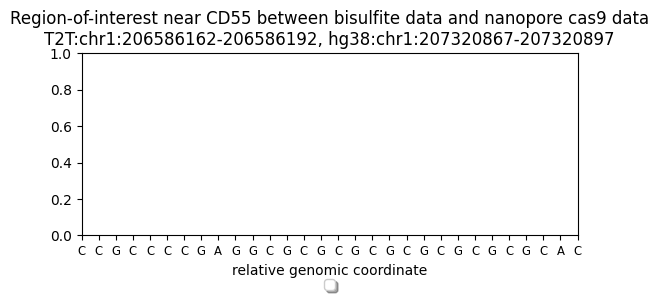

In [136]:
ax.plot(mC_frac,'*',label="mC_frac_mir") # Path(file).name)

ax.plot(pileup_frac,'*',label="pileup_frac") # Path(file).name)


plt.title(f'Region-of-interest near CD55 between bisulfite data and nanopore cas9 data\nT2T:{t2t_cd55}, hg38:{hg38_cd55}')
plt.xlabel('relative genomic coordinate')
# plt.legend()
plt.subplots_adjust(bottom=0.5)  # Adjust the bottom
# Placing the legend at the bottom outside of the figure
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), shadow=True, ncol=2)

seq = pysam.FastaFile(ref_genome_v1_1_file).fetch('chr1',206586162,206586192)
print(seq)
seq_list =  [s for s in seq]
plt.xticks(range(len(seq_list)), seq_list, size='small')

fig.show()

# TODO:
for each read:
- check their start and end coords => ensure that the value is 0 or np.nan if outside of the read


-> check if there are reads with empty values that lead to us having only ~700 reads - those their names=number - are actually going up to 920 - as expected! So probably the difference between 920 and ~700 is the reads that don't have any signal there?

=> lets

- extract the reads info from the hdf5 files:  https://colab.research.google.com/drive/1oY7rD9JOmwy69g9uOMH1fH_CDbHpzDIU#scrollTo=l14q8XtpL6bm

and see how many read actually don't have signal there and how many have np.nan values -> that shouldn't contribute to the frac values :)




In [137]:
np.nan

nan

# Build matrixes of fixed regions of the chromosome



In [138]:
coord_start =  206532289

206532289
# 2065689

206532289

In [139]:
window_length = 3

coord_end = coord_start + window_length
coord_end

206532292

In [140]:
# coords with CpGs
206568912
206568912
206569012

206569012

In [141]:
coord_start = 206568910
# 206568912
coord_end = 206568992

window_length = coord_end - coord_start +1

window_length

83

b'str' === byte string
https://stackoverflow.com/questions/6269765/what-does-the-b-character-do-in-front-of-a-string-literal

In [142]:
f.keys()

NameError: name 'f' is not defined

In [143]:
read_num = 1

str(f['ref_seq'][read_num][:3])

NameError: name 'f' is not defined

In [ ]:
f['ref_seq'][read_num][3:4].decode('UTF-8')

In [ ]:
f['valCpG'][read_num][3].dtype # :4].decode('UTF-8')

In [ ]:
f['modCpG'][read_num][3]#.dtype # :4].decode('UTF-8')

# select the data from region on interest (coord_start, coord_end)

In [144]:
read_num, print("is_forward", f["is_forward"][read_num])


NameError: name 'f' is not defined

In [ ]:
print("is_forward", f["is_forward"][read_num])


In [ ]:
# TODO: Coorect for the case when not the full len of the ROI is present in the read = PAD arround?

def get_read_info_in_region_of_interest(read_num, chr, coord_start, coord_end, f):
  f["chr"][read_num] == chr
  read_len = f["reference_coordinates"][read_num].shape[0]
  print("read_len", read_len)



  ref_seq = ""
  valCpG = []
  modCpG = []
  coord_start_index = -1
  coord_end_index = -1

  print("is_forward", f["is_forward"][read_num])

  for coord_i in range(read_len):
    read_coord_i = f["reference_coordinates"][read_num][coord_i]

    if  read_coord_i >= coord_start and  read_coord_i <= coord_end:
      # print(read_coord_i)
      # ref_coord_i < for ref_coord_i in f["reference_coordinates"][read_num]]\


      # save the ref genome
      # print('f["ref_seq"][read_num][coord_i:coord_i+1].decode("UTF-8")', f["ref_seq"][read_num][coord_i:coord_i+1].decode('UTF-8'))
      ref_seq += f["ref_seq"][read_num][coord_i:coord_i+1].decode('UTF-8')

      # save the valCpG coords
      valCpG.append(f['valCpG'][read_num][coord_i])
      # sace the modCpG annotation of that region
      modCpG.append(f['modCpG'][read_num][coord_i])

      # plot sequence + CpG annotations! (+check in genome browser for the t2t.v1.1 ref)

      # todo:
      # save list of coords:
      # Save the first coordinate:
      if coord_start_index == -1:
        coord_start_index = coord_i


    if read_coord_i == coord_end:
      # Assuming that all the coords are orfered in a sorted way
      coord_end_index = coord_i + 1 # last coord + 1 = the end of the region of interest coord

      break

  # TODO: Coorect for the case when not the full len of the ROI is present in the read = PAD arround?
  if coord_end_index == -1:
    # Add padding:
    # a = (a + N * [''])[:N]
    # coord_end_index
    print("NEED TO ADD PADDING")


  valCpG = np.array(valCpG)
  modCpG = np.array(modCpG)

  print("ref_seq", ref_seq)
  print("coord_start_index", coord_start_index)
  print("coord_end_index", coord_end_index)
  print("len", coord_end_index - coord_start_index)

  return(ref_seq, valCpG, modCpG, coord_end_index, coord_start_index)



read_num = 16
chr = b'chr1' # "chr1"

ref_seq, valCpG, modCpG, coord_end_index, coord_start_index = get_read_info_in_region_of_interest(read_num, chr, coord_start, coord_end, f)
ref_seq, valCpG, modCpG, coord_end_index, coord_start_index

In [ ]:
sum(valCpG), valCpG

In [ ]:
modCpG

In [ ]:
len(modCpG)

In [ ]:
len(ref_seq), ref_seq

# For the new package output addopt: instead of looking at f -> look at the dimelo exctract output

In [ ]:
# TODO: Coorect for the case when not the full len of the ROI is present in the read = PAD arround?

def get_read_info_in_region_of_interest(read_num, chr, coord_start, coord_end, f):
  f["chr"][read_num] == chr
  read_len = f["reference_coordinates"][read_num].shape[0]
  print("read_len", read_len)



  ref_seq = ""
  valCpG = []
  modCpG = []
  coord_start_index = -1
  coord_end_index = -1

  print("is_forward", f["is_forward"][read_num])

  for coord_i in range(read_len):
    read_coord_i = f["reference_coordinates"][read_num][coord_i]

    if  read_coord_i >= coord_start and  read_coord_i <= coord_end:
      # print(read_coord_i)
      # ref_coord_i < for ref_coord_i in f["reference_coordinates"][read_num]]\


      # save the ref genome
      # print('f["ref_seq"][read_num][coord_i:coord_i+1].decode("UTF-8")', f["ref_seq"][read_num][coord_i:coord_i+1].decode('UTF-8'))
      ref_seq += f["ref_seq"][read_num][coord_i:coord_i+1].decode('UTF-8')

      # save the valCpG coords
      valCpG.append(f['valCpG'][read_num][coord_i])
      # sace the modCpG annotation of that region
      modCpG.append(f['modCpG'][read_num][coord_i])

      # plot sequence + CpG annotations! (+check in genome browser for the t2t.v1.1 ref)

      # todo:
      # save list of coords:
      # Save the first coordinate:
      if coord_start_index == -1:
        coord_start_index = coord_i


    if read_coord_i == coord_end:
      # Assuming that all the coords are orfered in a sorted way
      coord_end_index = coord_i + 1 # last coord + 1 = the end of the region of interest coord

      break

  # TODO: Coorect for the case when not the full len of the ROI is present in the read = PAD arround?
  if coord_end_index == -1:
    # Add padding:
    # a = (a + N * [''])[:N]
    # coord_end_index
    print("NEED TO ADD PADDING")


  valCpG = np.array(valCpG)
  modCpG = np.array(modCpG)

  print("ref_seq", ref_seq)
  print("coord_start_index", coord_start_index)
  print("coord_end_index", coord_end_index)
  print("len", coord_end_index - coord_start_index)

  return(ref_seq, valCpG, modCpG, coord_end_index, coord_start_index)



read_num = 16
chr = b'chr1' # "chr1"

ref_seq, valCpG, modCpG, coord_end_index, coord_start_index = get_read_info_in_region_of_interest(read_num, chr, coord_start, coord_end, f)
ref_seq, valCpG, modCpG, coord_end_index, coord_start_index

## <?> Both CpG and GpC pairs?? -> having a valCpG and modification signal?

In [ ]:
# import plotly.graph_objects as go

# fig = go.Figure(go.Scatter(
#     mode = "lines+markers",
#     y = [4, 1, 3],
#     x = ["December", "January", "February"]))

# fig.update_xaxes(
#         tickangle = 90,
#         title_text = "Month",
#         title_font = {"size": 20},
#         title_standoff = 25)

# fig.update_yaxes(
#         title_text = "Temperature",
#         title_standoff = 25)

# fig.show()

In [ ]:
# import plotly.graph_objects as go

# fig = go.Figure(go.Scatter(
#     mode = "lines+markers",
#     y = valCpG, # [4, 1, 3],
#     x = list(ref_seq) #["December", "January", "February"]
#     ))

# fig.update_xaxes(
#         tickangle = 90,
#         title_text = "Month",
#         title_font = {"size": 20},
#         title_standoff = 25)

# fig.update_yaxes(
#         title_text = "Temperature",
#         title_standoff = 25)

# fig.show()

In [ ]:
# import plotly.graph_objects as go
# import pandas as pd

# # Load and filter Apple stock data for 2016
# apple_df = pd.read_csv(
#     "https://raw.githubusercontent.com/plotly/datasets/master/finance-charts-apple.csv",
#     parse_dates=["Date"],
#     index_col="Date"
# )

# apple_df_2016 = apple_df["2016"]

# # Create figure and add line
# fig = go.Figure()
# fig.add_trace(go.Scatter(
#     x=apple_df_2016.index,
#     y=apple_df_2016["AAPL.High"],
#     mode="lines"
# ))

# # Set custom x-axis labels
# fig.update_xaxes(
#     ticktext=["End of Q1", "End of Q2", "End of Q3", "End of Q4"],
#     tickvals=["2016-04-01", "2016-07-01", "2016-10-01", apple_df_2016.index.max()],
# )

# # Prefix y-axis tick labels with dollar sign
# fig.update_yaxes(tickprefix="$")

# # Set figure title
# fig.update_layout(title_text="Apple Stock Price")

# fig.show()

In [ ]:
# # Code Example: https://stackoverflow.com/questions/50128668/how-to-adjust-tick-frequency-for-string-x-axis

# import matplotlib.pyplot as plt
# import numpy as np

# x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
#     14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
#     25, 26, 27, 28, 29, 30, 31, 32]

# y = [1, 4, 9, 6, 2, 4, 5, 6, 7, 2, 1,
#      4, 6, 5, 2, 3, 1, 4, 9, 6, 2, 4,
#      5, 6, 7, 2, 1, 4, 6, 5, 2, 3]

# labels = ["Ant", "Bob", "Crab", "Donkey", "Elephant", "Fire", "Giant","Hello",
#           "Igloo", "Jump", "Bull","Even", "More", "Words", "other", "Bazboo",
#           "Ant", "Bob", "Crab", "Donkey", "Hippo", "Fire", "Giant","Hello",
#           "Igloo", "Hump", "Kellogg","Even", "More", "Words", "Piano", "Foobar"]

# # plt.xticks(x, labels[::2], rotation='vertical')
# # plt.locator_params(axis='x', nbins=len(x)/2)
# plt.plot(x, y, 'g-', color='red')
# # plt.tight_layout(pad=4)
# # plt.subplots_adjust(bottom=0.15)
# # plt.show()
# # Using plt.locator_params and the length of your list it could be divided in half for example:

# # plt.xticks(x, labels[::2], rotation='vertical') # set divisor
# # plt.locator_params(axis='x', nbins=len(x)/2)  # set divisor
# # plot 1

# # This should display half the number of ticks (x / 2) while keeping your plot uniform. This will work on strings and integers since the length (len) of x is working from a list.

# plt.xticks(x, labels, rotation='vertical')
# plt.xticks(rotation=45)
# plt.locator_params(axis='x', nbins=len(x))

<ipython-input-76-808a3e7e05f2>:7: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "g-" (-> color='g'). The keyword argument will take precedence.



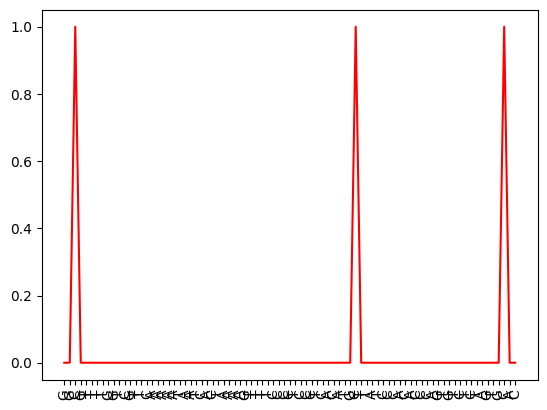

In [ ]:
y = valCpG
x = np.arange(len(valCpG))
labels = list(ref_seq)



plt.plot(x, y, 'g-', color='red')
# plt.tight_layout(pad=4)
# plt.subplots_adjust(bottom=0.15)
# plt.show()
# Using plt.locator_params and the length of your list it could be divided in half for example:

# plt.xticks(x, labels[::2], rotation='vertical') # set divisor
# plt.locator_params(axis='x', nbins=len(x)/2)  # set divisor
# plot 1

# This should display half the number of ticks (x / 2) while keeping your plot uniform. This will work on strings and integers since the length (len) of x is working from a list.

plt.xticks(x, labels, rotation='vertical')
plt.xticks(rotation=90) #45

plt.locator_params(axis='x', nbins=len(x))

In [ ]:
# import plotly.graph_objects as go


# fig = go.Figure(go.Scatter(
#     x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
#     y = [28.8, 28.5, 37, 56.8, 69.7, 79.7, 78.5, 77.8, 74.1, 62.6, 45.3, 39.9]
# ))

# fig.update_layout(
#     xaxis = dict(
#         tickmode = 'array',
#         tickvals = [1, 3, 5, 7, 9, 11],
#         ticktext = ['One', 'Three', 'Five', 'Seven', 'Nine', 'Eleven']
#     )
# )

# fig.show()

In [ ]:
import plotly.graph_objects as go

y = valCpG
x = np.arange(len(valCpG))
labels = list(ref_seq)


fig = go.Figure(go.Scatter(
    x = x, # [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    y = y #[28.8, 28.5, 37, 56.8, 69.7, 79.7, 78.5, 77.8, 74.1, 62.6, 45.3, 39.9]
))

fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = x, # [1, 3, 5, 7, 9, 11],
        ticktext = labels # ['One', 'Three', 'Five', 'Seven', 'Nine', 'Eleven']
    )
)

fig.show()

In [ ]:

import plotly.graph_objects as go

y = valCpG
x = np.arange(len(valCpG))
labels = list(ref_seq)


fig = px.scatter( #go.Figure(go.Scatter(
    x = x, # [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    y = y #[28.8, 28.5, 37, 56.8, 69.7, 79.7, 78.5, 77.8, 74.1, 62.6, 45.3, 39.9]
) # )

fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = x, # [1, 3, 5, 7, 9, 11],
        ticktext = labels # ['One', 'Three', 'Five', 'Seven', 'Nine', 'Eleven']
    )
)

fig.update_xaxes(
        tickangle = 0,
        title_text = "DNS",
        title_font = {"size": 16},
        title_standoff = 20)

fig.show()

In [ ]:
import plotly.graph_objects as go

# Create random data with numpy
import numpy as np
np.random.seed(1)

N = 100
random_x = np.linspace(0, 1, N)
random_y0 = np.random.randn(N) + 5
random_y1 = np.random.randn(N)
random_y2 = np.random.randn(N) - 5

fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=random_x, y=random_y0,
                    mode='markers',
                    name='markers'))
fig.add_trace(go.Scatter(x=random_x, y=random_y1,
                    mode='lines+markers',
                    name='lines+markers'))
fig.add_trace(go.Scatter(x=random_x, y=random_y2,
                    mode='lines',
                    name='lines'))

fig.show()

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

read_num = 0
chr = b'chr1' # "chr1"
ref_seq, valCpG, modCpG, coord_end_index, coord_start_index = get_read_info_in_region_of_interest(read_num, chr, coord_start, coord_end, f)

y = valCpG
x = np.arange(len(valCpG))
labels = list(ref_seq)

# Add traces
fig.add_trace(go.Scatter(x=x, y=valCpG,
                    mode='markers',
                    name='valCpG_read_' + str(read_num),
                    opacity=0.5,))

# Add traces
fig.add_trace(go.Scatter(x=x, y=modCpG,
                    mode='markers',
                    name='modCpG_read_' + str(read_num),
                    opacity=0.5,))

fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = x, # [1, 3, 5, 7, 9, 11],
        ticktext = labels, # ['One', 'Three', 'Five', 'Seven', 'Nine', 'Eleven']
        tickangle = 0,
    )
)


fig.show()

read_len 50762
is_forward False
ref_seq GGCGTTTTGGTCGTTCAAAAATAATCACTAAAAGTTTTCCCCTCCCTCACATGCTTATCCCACACCCAGTGTCTCTAGTGCAC
coord_start_index 36623
coord_end_index 36706
len 83


In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

chr = b'chr1' # "chr1"

for read_num in range(8):
  ref_seq, valCpG, modCpG, coord_end_index, coord_start_index = get_read_info_in_region_of_interest(read_num, chr, coord_start, coord_end, f)
  y = valCpG
  x = np.arange(len(valCpG))
  labels = list(ref_seq)
  # Add traces
  fig.add_trace(go.Scatter(x=x, y=valCpG,
                      mode='markers',
                      name='valCpG_read_' + str(read_num),
                      opacity=0.5,))
  # Add traces
  fig.add_trace(go.Scatter(x=x, y=modCpG,
                      mode='markers',
                      name='modCpG_read_' + str(read_num),
                      opacity=0.5,))


fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = x,
        ticktext = labels,
        tickangle = 0,
    )
)


fig.show()

read_len 50762
is_forward False
ref_seq GGCGTTTTGGTCGTTCAAAAATAATCACTAAAAGTTTTCCCCTCCCTCACATGCTTATCCCACACCCAGTGTCTCTAGTGCAC
coord_start_index 36623
coord_end_index 36706
len 83
read_len 41870
is_forward False
ref_seq GGCGTTTTGGTCGTTCAAAAATAATCACTAAAAGTTTTCCCCTCCCTCACATGCTTATCCCACACCCAGTGTCTCTAGTGCAC
coord_start_index 27729
coord_end_index 27812
len 83
read_len 40122
is_forward False
ref_seq GGCGTTTTGGTCGTTCAAAAATAATCACTAAAAGTTTTCCCCTCCCTCACATGCTTATCCCACACCCAGTGTCTCTAGTGCAC
coord_start_index 18919
coord_end_index 19002
len 83
read_len 32965
is_forward False
ref_seq GGCGTTTTGGTCGTTCAAAAATAATCACTAAAAGTTTTCCCCTCCCTCACATGCTTATCCCACACCCAGTGTCTCTAGTGCAC
coord_start_index 18822
coord_end_index 18905
len 83
read_len 28865
is_forward False
ref_seq GGCGTTTTGGTCGTTCAAAAATAATCACTAAAAGTTTTCCCCTCCCTCACATGCTTATCCCACACCCAGTGTCTCTAGTGCAC
coord_start_index 14724
coord_end_index 14807
len 83
read_len 26395
is_forward False
ref_seq GGCGTTTTGGTCGTTCAAAAATAATCACTAAAAGTTTTCCCCTCCCTCACATGCTTATCCCACACCCAGTGTCTC

# <?> the ref_seq is already complimentary (not reversed for the "not forward (is_forward == False) reads?

# todo:
- extract the information of the region of interest for the MANY / all reads

- plot agrigated (histograms) for the values of the reads

-

In [ ]:
f["reference_coordinates"][read_num]

array([206558138, 206558139, 206558140, ..., 206583034, 206583035,
       206583036])

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

chr = b'chr1' # "chr1"


ref_seq_ROI = []
valCpG_ROI = []
modCpG_ROI = []

for read_num in range(50): #(f['read_name'][0].shape[0])
  print("read_num", read_num)
  # read_i = f[read_num]
  # print("read_i", read_i)

  ref_seq_i, valCpG_i, modCpG_i, coord_end_index_i, coord_start_index_i = get_read_info_in_region_of_interest(read_num, chr, coord_start, coord_end, f)

  ref_seq_ROI.append(ref_seq_i)

  valCpG_ROI.append(valCpG_i)
  modCpG_ROI.append(modCpG_i)

  y = valCpG_i

  labels = list(ref_seq_i)
  # Add traces
  fig.add_trace(go.Scatter(x=x, y=valCpG_i,
                      mode='markers',
                      name='valCpG_read_' + str(read_num),
                      opacity=0.5,))
  # Add traces
  fig.add_trace(go.Scatter(x=x, y=modCpG_i,
                      mode='markers',
                      name='modCpG_read_' + str(read_num),
                      opacity=0.5,))


x = np.arange(len(ref_seq_ROI[0]))
labels = list(ref_seq_ROI[0])

fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = x,
        ticktext = labels,
        tickangle = 0,
    )
)


fig.show()

read_num 0
read_len 50762
is_forward False
ref_seq GGCGTTTTGGTCGTTCAAAAATAATCACTAAAAGTTTTCCCCTCCCTCACATGCTTATCCCACACCCAGTGTCTCTAGTGCAC
coord_start_index 36623
coord_end_index 36706
len 83
read_num 1
read_len 41870
is_forward False
ref_seq GGCGTTTTGGTCGTTCAAAAATAATCACTAAAAGTTTTCCCCTCCCTCACATGCTTATCCCACACCCAGTGTCTCTAGTGCAC
coord_start_index 27729
coord_end_index 27812
len 83
read_num 2
read_len 40122
is_forward False
ref_seq GGCGTTTTGGTCGTTCAAAAATAATCACTAAAAGTTTTCCCCTCCCTCACATGCTTATCCCACACCCAGTGTCTCTAGTGCAC
coord_start_index 18919
coord_end_index 19002
len 83
read_num 3
read_len 32965
is_forward False
ref_seq GGCGTTTTGGTCGTTCAAAAATAATCACTAAAAGTTTTCCCCTCCCTCACATGCTTATCCCACACCCAGTGTCTCTAGTGCAC
coord_start_index 18822
coord_end_index 18905
len 83
read_num 4
read_len 28865
is_forward False
ref_seq GGCGTTTTGGTCGTTCAAAAATAATCACTAAAAGTTTTCCCCTCCCTCACATGCTTATCCCACACCCAGTGTCTCTAGTGCAC
coord_start_index 14724
coord_end_index 14807
len 83
read_num 5
read_len 26395
is_forward False
ref_seq GGCGTTTTG

In [ ]:
valCpG_ROI

[array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]),
 array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]),
 array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]),
 array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
   

In [ ]:

x = np.arange(len(ref_seq_ROI[0]))
labels = list(ref_seq_ROI[0])
x, labels

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82]),
 ['G',
  'G',
  'C',
  'G',
  'T',
  'T',
  'T',
  'T',
  'G',
  'G',
  'T',
  'C',
  'G',
  'T',
  'T',
  'C',
  'A',
  'A',
  'A',
  'A',
  'A',
  'T',
  'A',
  'A',
  'T',
  'C',
  'A',
  'C',
  'T',
  'A',
  'A',
  'A',
  'A',
  'G',
  'T',
  'T',
  'T',
  'T',
  'C',
  'C',
  'C',
  'C',
  'T',
  'C',
  'C',
  'C',
  'T',
  'C',
  'A',
  'C',
  'A',
  'T',
  'G',
  'C',
  'T',
  'T',
  'A',
  'T',
  'C',
  'C',
  'C',
  'A',
  'C',
  'A',
  'C',
  'C',
  'C',
  'A',
  'G',
  'T',
  'G',
  'T',
  'C',
  'T',
  'C',
  'T',
  'A',
  'G',
  'T',
  'G',
  'C',
  'A',
  'C'])

In [ ]:

x = np.arange(len(ref_seq_ROI[0]))
labels = list(ref_seq_ROI[0])

fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = x,
        ticktext = labels,
        tickangle = 0,
    )
)


fig.show()

In [ ]:
import plotly.express as px
data=  [[1, 25, 30, 50, 1], [20, 1, 60, 80, 30], [30, 60, 1, 5, 20]]
fig = px.imshow(data,
                labels=dict(x="Day of Week", y="Time of Day", color="Productivity"),
                x=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
                y=['Morning', 'Afternoon', 'Evening']
               )
fig.update_xaxes(side="top")
fig.show()

In [ ]:
import plotly.express as px
data= valCpG_ROI[:20] # [[1, 25, 30, 50, 1], [20, 1, 60, 80, 30], [30, 60, 1, 5, 20]]
fig = px.imshow(data,
                # labels=dict(x="Day of Week", y="Time of Day", color="Productivity"),
                # x=labels, #['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
                # y=['Morning', 'Afternoon', 'Evening']
               )
# fig.update_xaxes(side="bottom")

fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = x,
        ticktext = labels,
        tickangle = 0,
    )
)
fig.show()

Check if all elements in a list are identical  https://www.geeksforgeeks.org/python-check-if-all-elements-in-a-list-are-identical/

In [ ]:
import itertools


def check_identical(lst):
    groups = list(itertools.groupby(lst))
    print("list groups = ", groups)
    print("len list groups = ", len(groups))
    return len(groups) == 1



lst = ['a', 'b', 'c']
print(check_identical(lst))

lst = [1, 1, 1]
print(check_identical(lst))

list groups =  [('a', <itertools._grouper object at 0x78f2969040a0>), ('b', <itertools._grouper object at 0x78f2969051e0>), ('c', <itertools._grouper object at 0x78f296905930>)]
len list groups =  3
False
list groups =  [(1, <itertools._grouper object at 0x78f296905750>)]
len list groups =  1
True


In [ ]:
# groups = itertools.groupby(lst)
# print("list groups = ", list(groups))
# print("len list groups = ", len(list(groups)))
# # return len(list(groups)) == 1
# list(groups)

In [ ]:
check_identical(ref_seq_ROI), ref_seq_ROI

list groups =  [('GGCGTTTTGGTCGTTCAAAAATAATCACTAAAAGTTTTCCCCTCCCTCACATGCTTATCCCACACCCAGTGTCTCTAGTGCAC', <itertools._grouper object at 0x78f296904340>), ('CCGCAAAACCAGCAAGTTTTTATTAGTGATTTTCAAAAGGGGAGGGAGTGTACGAATAGGGTGTGGGTCACAGAGATCACGTG', <itertools._grouper object at 0x78f2969061d0>), ('GGCGTTTTGGTCGTTCAAAAATAATCACTAAAAGTTTTCCCCTCCCTCACATGCTTATCCCACACCCAGTGTCTCTAGTGCAC', <itertools._grouper object at 0x78f2969040d0>), ('', <itertools._grouper object at 0x78f2969044f0>)]
len list groups =  4


(False,
 ['GGCGTTTTGGTCGTTCAAAAATAATCACTAAAAGTTTTCCCCTCCCTCACATGCTTATCCCACACCCAGTGTCTCTAGTGCAC',
  'GGCGTTTTGGTCGTTCAAAAATAATCACTAAAAGTTTTCCCCTCCCTCACATGCTTATCCCACACCCAGTGTCTCTAGTGCAC',
  'GGCGTTTTGGTCGTTCAAAAATAATCACTAAAAGTTTTCCCCTCCCTCACATGCTTATCCCACACCCAGTGTCTCTAGTGCAC',
  'GGCGTTTTGGTCGTTCAAAAATAATCACTAAAAGTTTTCCCCTCCCTCACATGCTTATCCCACACCCAGTGTCTCTAGTGCAC',
  'GGCGTTTTGGTCGTTCAAAAATAATCACTAAAAGTTTTCCCCTCCCTCACATGCTTATCCCACACCCAGTGTCTCTAGTGCAC',
  'GGCGTTTTGGTCGTTCAAAAATAATCACTAAAAGTTTTCCCCTCCCTCACATGCTTATCCCACACCCAGTGTCTCTAGTGCAC',
  'GGCGTTTTGGTCGTTCAAAAATAATCACTAAAAGTTTTCCCCTCCCTCACATGCTTATCCCACACCCAGTGTCTCTAGTGCAC',
  'CCGCAAAACCAGCAAGTTTTTATTAGTGATTTTCAAAAGGGGAGGGAGTGTACGAATAGGGTGTGGGTCACAGAGATCACGTG',
  'GGCGTTTTGGTCGTTCAAAAATAATCACTAAAAGTTTTCCCCTCCCTCACATGCTTATCCCACACCCAGTGTCTCTAGTGCAC',
  'GGCGTTTTGGTCGTTCAAAAATAATCACTAAAAGTTTTCCCCTCCCTCACATGCTTATCCCACACCCAGTGTCTCTAGTGCAC',
  'GGCGTTTTGGTCGTTCAAAAATAATCACTAAAAGTTTTCCCCTCCCTCACATGCTTATCCCACACCCAGTGTCTCTAGTGCAC',
  'GGCGTTTTGG

In [ ]:
ref_seq_ROI[0] == ref_seq_ROI[16]

True

-> check for "\n"?
Add letter 'N'?

=> 2 types - forward and reverse ref sequences

4 differenet seq?
=> What's the 3d category??? Missmatches???

# TODO:

- separate to 2 groups = FWD and REV reads?

- get the region of interest - aligned with the Dif expressed region

Check that all the dimentions are the same = no coords are missing?

-

In [ ]:
def get_subarryas_lens(valCpG_ROI):
 return [len(valCpG_i) for valCpG_i in valCpG_ROI]

valCpG_ROI_lens = get_subarryas_lens(valCpG_ROI)

check_identical(valCpG_ROI_lens), valCpG_ROI_lens

list groups =  [(83, <itertools._grouper object at 0x78f29ee3ea10>), (0, <itertools._grouper object at 0x78f29ee3e2f0>)]
len list groups =  2


(False,
 [83,
  83,
  83,
  83,
  83,
  83,
  83,
  83,
  83,
  83,
  83,
  83,
  83,
  83,
  83,
  83,
  83,
  83,
  83,
  83,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0])

In [ ]:
modCpG_ROI_lens = get_subarryas_lens(modCpG_ROI)
check_identical(modCpG_ROI_lens), modCpG_ROI_lens

list groups =  [(83, <itertools._grouper object at 0x78f29ee3e2f0>), (0, <itertools._grouper object at 0x78f29ee3e9b0>)]
len list groups =  2


(False,
 [83,
  83,
  83,
  83,
  83,
  83,
  83,
  83,
  83,
  83,
  83,
  83,
  83,
  83,
  83,
  83,
  83,
  83,
  83,
  83,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0])

In [ ]:
import numpy as np

# dset[...] = np.arange(622)
# dset[0]
# # 0
# dset[10]
# # 10
# dset[0:622:10]

# !!!!  START THE hdf5 of the new data here !!!!

# Look at the Dif. methylation:

 UCSC Genome Browser on Human
In GRCh38/hg38:

chr1:207,320,866-207,320,894

In T2T.v2.0 :

chr1:206586162-206586192

converted using hgLiftOver : https://genome.ucsc.edu/cgi-bin/hgLiftOver

In [ ]:
coord_start = 206586162
coord_end = 206586192
coord_start, coord_end

(206586162, 206586192)

In [ ]:
read_num, chr, coord_start, coord_end, f

(16,
 b'chr1',
 206586162,
 206586192,
 <HDF5 file "nCATs_CD55-tss_chr1_206586162-206586192_hdf5.h5" (mode r)>)

In [ ]:
coord_end - coord_start

30

In [ ]:
read_num = 300
chr = b'chr1' # "chr1"

ref_seq, valCpG, modCpG, coord_end_index, coord_start_index = get_read_info_in_region_of_interest(read_num, chr, coord_start, coord_end, f)
ref_seq, valCpG, modCpG, coord_end_index, coord_start_index

read_len 6152
is_forward False
ref_seq GGCGGGGCTCCGCGCGCGCGCGCGCGCGTGT
coord_start_index 2263
coord_end_index 2294
len 31


('GGCGGGGCTCCGCGCGCGCGCGCGCGCGTGT',
 array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 1, 0, 1, 0, 0, 0, 0]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 2294,
 2263)

In [ ]:
import plotly.graph_objects as go

def get_reads_in_ROI(chr, coord_start, coord_end, f, first_N_reads, do_plot=True):
  '''
    first_N_reads - int - look within the "first_N_reads"
    do_plot - bool - make plots
  '''

  ref_seq_ROI = []
  valCpG_ROI = []
  modCpG_ROI = []

  fig = go.Figure()

  for read_num in range(first_N_reads): #(f['read_name'][0].shape[0])
    print("read_num", read_num)
    # read_i = f[read_num]
    # print("read_i", read_i)

    ref_seq_i, valCpG_i, modCpG_i, coord_end_index_i, coord_start_index_i = get_read_info_in_region_of_interest(read_num, chr, coord_start, coord_end, f)

    ref_seq_ROI.append(ref_seq_i)

    valCpG_ROI.append(valCpG_i)
    modCpG_ROI.append(modCpG_i)

    y = valCpG_i

    labels = list(ref_seq_i)
    x = np.arange(len(ref_seq_i))
    # Add traces
    if do_plot:
      fig.add_trace(go.Scatter(x=x, y=valCpG_i,
                          mode='markers',
                          name='valCpG_read_' + str(read_num),
                          opacity=0.5,))
      # Add traces
      fig.add_trace(go.Scatter(x=x, y=modCpG_i,
                          mode='markers',
                          name='modCpG_read_' + str(read_num),
                          opacity=0.5,))


  x = np.arange(len(ref_seq_ROI[0]))
  labels = list(ref_seq_ROI[0])

  if do_plot:
    fig.update_layout(
        xaxis = dict(
            tickmode = 'array',
            tickvals = x,
            ticktext = labels,
            tickangle = 0,
        )
    )
    fig.show()

  return(ref_seq_ROI, valCpG_ROI, modCpG_ROI, fig)



first_N_reads = 3
ref_seq_ROI_DifM, valCpG_ROI_DifM, modCpG_ROI_DifM, fig = get_reads_in_ROI(chr, coord_start, coord_end, f, first_N_reads, do_plot=True)

read_num 0
read_len 40122
is_forward False
ref_seq GGCGGGGCTCCGCGCGCGCGCGCGCGCGTGT
coord_start_index 36171
coord_end_index 36202
len 31
read_num 1
read_len 16958
is_forward False
ref_seq GGCGGGGCTCCGCGCGCGCGCGCGCGCGTGT
coord_start_index 13189
coord_end_index 13220
len 31
read_num 2
read_len 14602
is_forward False
ref_seq GGCGGGGCTCCGCGCGCGCGCGCGCGCGTGT
coord_start_index 10651
coord_end_index 10682
len 31


In [ ]:

x = np.arange(len(ref_seq_ROI[2]))
labels = list(ref_seq_ROI[2])

do_plot = True
if do_plot:
  fig.update_layout(
      xaxis = dict(
          tickmode = 'array',
          tickvals = x,
          ticktext = labels,
          tickangle = 0,
      )
  )
  fig.show()


In [ ]:
f['read_name'].shape[0]

622

In [ ]:
f["ref_seq"].shape[0]

622

In [ ]:
%%time
first_N_reads = f["ref_seq"].shape[0]
ref_seq_ROI_DifM, valCpG_ROI_DifM, modCpG_ROI_DifM, fig_DifM = get_reads_in_ROI(chr, coord_start, coord_end, f, first_N_reads, do_plot=True)

read_num 0
read_len 50762
is_forward False
NEED TO ADD PADDING
ref_seq 
coord_start_index -1
coord_end_index -1
len 0
read_num 1
read_len 41870
is_forward False
NEED TO ADD PADDING
ref_seq 
coord_start_index -1
coord_end_index -1
len 0
read_num 2
read_len 40122
is_forward False
ref_seq GGCGGGGCTCCGCGCGCGCGCGCGCGCGTGT
coord_start_index 36171
coord_end_index 36202
len 31
read_num 3
read_len 32965
is_forward False
NEED TO ADD PADDING
ref_seq 
coord_start_index -1
coord_end_index -1
len 0
read_num 4
read_len 28865
is_forward False
NEED TO ADD PADDING
ref_seq 
coord_start_index -1
coord_end_index -1
len 0
read_num 5
read_len 26395
is_forward False
NEED TO ADD PADDING
ref_seq 
coord_start_index -1
coord_end_index -1
len 0
read_num 6
read_len 24929
is_forward False
NEED TO ADD PADDING
ref_seq 
coord_start_index -1
coord_end_index -1
len 0
read_num 7
read_len 24899
is_forward True
NEED TO ADD PADDING
ref_seq 
coord_start_index -1
coord_end_index -1
len 0
read_num 8
read_len 23955
is_forward Fa

In [ ]:

x = np.arange(len(ref_seq_ROI[2]))
labels = list(ref_seq_ROI[2])

do_plot = True
if do_plot:
  fig_DifM.update_layout(
      xaxis = dict(
          tickmode = 'array',
          tickvals = x,
          ticktext = labels,
          tickangle = 0,
      )
  )

fig_DifM.show()

## save into backup list copiest

In [ ]:
a, b, c = [1,1], [1,1], [1,1]
a, b, c

([1, 1], [1, 1], [1, 1])

In [ ]:
ref_seq_ROI_DifM_list, valCpG_ROI_DifM_list, modCpG_ROI_DifM_list = ref_seq_ROI_DifM, valCpG_ROI_DifM, modCpG_ROI_DifM

# Save the extracted read - their numbers and ROIs info?

In [ ]:

# ref_seq_ROI_DifM, valCpG_ROI_DifM, modCpG_ROI_DifM = np.array(ref_seq_ROI_Dif), np.array(valCpG_ROI_DifM), np.array(modCpG_ROI_DifM)

In [ ]:
# np.save(outfile, x)
# _ = outfile.seek(0) # Only needed here to simulate closing & reopening file
# np.load(outfile)

In [ ]:
path_to_data_dir = "/content/drive/MyDrive/Michal Rozenwald/data/CD55/CD55_cas9_experiments_20221114/exp3/h5py_oberon"
path_to_data_dir + "/ref_seq_ROI_DifM" + ".npy"

'/content/drive/MyDrive/Michal Rozenwald/data/CD55/CD55_cas9_experiments_20221114/exp3/h5py_oberon/ref_seq_ROI_DifM.npy'

In [ ]:
np.array(ref_seq_ROI_DifM)

array(['', '', 'GGCGGGGCTCCGCGCGCGCGCGCGCGCGTGT', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', 'GGCGGGGCTCCGCGCGCGCGCGCGCGCGTGT', '', '',
       '', '', '', '', '', '', '', '', '', '',
       'GGCGGGGCTCCGCGCGCGCGCGCGCGCGTGT', '', '', '', '', '', '', '', '',
       '', 'GGCGGGGCTCCGCGCGCGCGCGCGCGCGTGT', '',
       'GGCGGGGCTCCGCGCGCGCGCGCGCGCGTGT', '', '',
       'GGCGGGGCTCCGCGCGCGCGCGCGCGCGTGT', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', 'GGCGGGGCTCCGCGCGCGCGCGCGCGCGTGT', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', 'GGCGGGGCTCCGCGCGCGCGCGCGCGCGTGT',
       'GGCGGGGCTCCGCGCGCGCGCGCGCGCGTGT', '', '', '', '', '', '',
       'GGCGGGGCTCCGCGCGCGCGCGCGCGCGTGT',
       'GGCGGGGCTCCGCGCGCGCGCGCGCGCGTGT',
       'CCGCCCCGAGGCGCGCGCGCGCGCGCGCACA', '',
       'CCGCCCCGAGGCGCGCGCGCGCGCGCGCACA',
       'CCGCCCCGAGGCGCGCGCGCGCGCGCGCACA',

In [ ]:
save_path_name = path_to_data_dir + "/ref_seq_ROI_DifM" + "_chr1_206586162_206586192_all_reads.npy"
# np.save(save_path_name,  np.array(ref_seq_ROI_DifM))
np.load(save_path_name)

In [ ]:
np.array(valCpG_ROI_DifM, dtype=object)

array([array([], dtype=float64), array([], dtype=float64),
       array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
              1, 0, 1, 0, 1, 0, 0, 0, 0])                                      ,
       array([], dtype=float64), array([], dtype=float64),
       array([], dtype=float64), array([], dtype=float64),
       array([], dtype=float64), array([], dtype=float64),
       array([], dtype=float64), array([], dtype=float64),
       array([], dtype=float64), array([], dtype=float64),
       array([], dtype=float64), array([], dtype=float64),
       array([], dtype=float64), array([], dtype=float64),
       array([], dtype=float64), array([], dtype=float64),
       array([], dtype=float64), array([], dtype=float64),
       array([], dtype=float64), array([], dtype=float64),
       array([], dtype=float64), array([], dtype=float64),
       array([], dtype=float64), array([], dtype=float64),
       array([], dtype=float64), array([], dtype=float64),
       array(

In [ ]:
save_path_name = path_to_data_dir + "/valCpG_ROI_DifM" + "_chr1_206586162_206586192_all_reads.npy"
# np.save(save_path_name,  np.array(valCpG_ROI_DifM, dtype=object))
np.load(save_path_name, allow_pickle=True) #, dtype=object)

array([array([], dtype=float64), array([], dtype=float64),
       array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
              1, 0, 1, 0, 1, 0, 0, 0, 0])                                      ,
       array([], dtype=float64), array([], dtype=float64),
       array([], dtype=float64), array([], dtype=float64),
       array([], dtype=float64), array([], dtype=float64),
       array([], dtype=float64), array([], dtype=float64),
       array([], dtype=float64), array([], dtype=float64),
       array([], dtype=float64), array([], dtype=float64),
       array([], dtype=float64), array([], dtype=float64),
       array([], dtype=float64), array([], dtype=float64),
       array([], dtype=float64), array([], dtype=float64),
       array([], dtype=float64), array([], dtype=float64),
       array([], dtype=float64), array([], dtype=float64),
       array([], dtype=float64), array([], dtype=float64),
       array([], dtype=float64), array([], dtype=float64),
       array(

In [ ]:
save_path_name = path_to_data_dir + "/modCpG_ROI_DifM" + "_chr1_206586162_206586192_all_reads.npy"
# np.save(save_path_name,  np.array(modCpG_ROI_DifM, dtype=object))
np.load(save_path_name, allow_pickle=True) #, dtype=object)

array([array([], dtype=float64), array([], dtype=float64),
       array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])           ,
       array([], dtype=float64), array([], dtype=float64),
       array([], dtype=float64), array([], dtype=float64),
       array([], dtype=float64), array([], dtype=float64),
       array([], dtype=float64), array([], dtype=float64),
       array([], dtype=float64), array([], dtype=float64),
       array([], dtype=float64), array([], dtype=float64),
       array([], dtype=float64), array([], dtype=float64),
       array([], dtype=float64), array([], dtype=float64),
       array([], dtype=float64), array([], dtype=float64),
       array([], dtype=float64), array([], dtype=float64),
       array([], dtype=float64), array([], dtype=float64),
       array([], dtype=float64), array([], dtype=float64),
       array([], dtype=float64), array([], dtype=float64),
       ar

# Explore lengths of the reads

In [ ]:
def get_subarryas_lens(valCpG_ROI):
 return [len(valCpG_i) for valCpG_i in valCpG_ROI]

valCpG_ROI_lens = get_subarryas_lens(valCpG_ROI_DifM)

values, counts = np.unique(valCpG_ROI_lens, return_counts=True)
values, counts

(array([ 0, 16, 31]), array([294,   1, 327]))

In [ ]:
modCpG_ROI_lens = get_subarryas_lens(modCpG_ROI_DifM)

values, counts = np.unique(modCpG_ROI_lens, return_counts=True)
values, counts

(array([ 0, 16, 31]), array([294,   1, 327]))

In [ ]:
ref_seq_ROI_DifM_lens = get_subarryas_lens(ref_seq_ROI_DifM)

values, counts = np.unique(ref_seq_ROI_DifM_lens, return_counts=True)
values, counts

(array([ 0, 16, 31]), array([294,   1, 327]))

Get indexes of NON empty reads

In [ ]:
len(ref_seq_ROI_DifM_lens)

622

In [ ]:
# non_empty_reads_mask = np.array([ref_seq_ROI_DifM_lens[i] != 0 for i in range(len(ref_seq_ROI_DifM_lens))])
# non_empty_reads_mask

In [ ]:
target_lenth = 31
non_empty_reads_mask = np.array([ref_seq_ROI_DifM_lens[i] == target_lenth for i in range(len(ref_seq_ROI_DifM_lens))])
non_empty_reads_mask

array([False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False,  True, False,  True, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True, False, False, False, False, False, False,  True,  True,
        True, False,  True,  True, False, False,  True, False, False,
       False,  True, False,  True,  True, False,  True,  True,  True,
        True,  True,

In [ ]:
sum(non_empty_reads_mask)

327

## Keep only the non empty read
- remove the reads with empty lengths


In [ ]:
# ref_seq_ROI_DifM, valCpG_ROI_DifM, modCpG_ROI_DifM

(['',
  '',
  'GGCGGGGCTCCGCGCGCGCGCGCGCGCGTGT',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  'GGCGGGGCTCCGCGCGCGCGCGCGCGCGTGT',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  'GGCGGGGCTCCGCGCGCGCGCGCGCGCGTGT',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  'GGCGGGGCTCCGCGCGCGCGCGCGCGCGTGT',
  '',
  'GGCGGGGCTCCGCGCGCGCGCGCGCGCGTGT',
  '',
  '',
  'GGCGGGGCTCCGCGCGCGCGCGCGCGCGTGT',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  'GGCGGGGCTCCGCGCGCGCGCGCGCGCGTGT',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  'GGCGGGGCTCCGCGCGCGCGCGCGCGCGTGT',
  'GGCGGGGCTCCGCGCGCGCGCGCGCGCGTGT',
  '',
  '',
  '',
  '',
  '',
  '',
  'GGCGGGGCTCCGCGCGCGCGCGCGCGCGTGT',
  'GGCGGGGCTCCGCGCGCGCGCGCGCGCGTGT',
  'CCGCCCCG

In [ ]:
ref_seq_ROI_DifM = np.array(ref_seq_ROI_DifM)[non_empty_reads_mask]
len(ref_seq_ROI_DifM), ref_seq_ROI_DifM

(327,
 array(['GGCGGGGCTCCGCGCGCGCGCGCGCGCGTGT',
        'GGCGGGGCTCCGCGCGCGCGCGCGCGCGTGT',
        'GGCGGGGCTCCGCGCGCGCGCGCGCGCGTGT',
        'GGCGGGGCTCCGCGCGCGCGCGCGCGCGTGT',
        'GGCGGGGCTCCGCGCGCGCGCGCGCGCGTGT',
        'GGCGGGGCTCCGCGCGCGCGCGCGCGCGTGT',
        'GGCGGGGCTCCGCGCGCGCGCGCGCGCGTGT',
        'GGCGGGGCTCCGCGCGCGCGCGCGCGCGTGT',
        'GGCGGGGCTCCGCGCGCGCGCGCGCGCGTGT',
        'GGCGGGGCTCCGCGCGCGCGCGCGCGCGTGT',
        'GGCGGGGCTCCGCGCGCGCGCGCGCGCGTGT',
        'CCGCCCCGAGGCGCGCGCGCGCGCGCGCACA',
        'CCGCCCCGAGGCGCGCGCGCGCGCGCGCACA',
        'CCGCCCCGAGGCGCGCGCGCGCGCGCGCACA',
        'CCGCCCCGAGGCGCGCGCGCGCGCGCGCACA',
        'CCGCCCCGAGGCGCGCGCGCGCGCGCGCACA',
        'CCGCCCCGAGGCGCGCGCGCGCGCGCGCACA',
        'CCGCCCCGAGGCGCGCGCGCGCGCGCGCACA',
        'CCGCCCCGAGGCGCGCGCGCGCGCGCGCACA',
        'CCGCCCCGAGGCGCGCGCGCGCGCGCGCACA',
        'CCGCCCCGAGGCGCGCGCGCGCGCGCGCACA',
        'CCGCCCCGAGGCGCGCGCGCGCGCGCGCACA',
        'CCGCCCCGAGGCGCGCGCGCGCGCGCGCACA',
     

In [ ]:
valCpG_ROI_DifM = np.array(valCpG_ROI_DifM)[non_empty_reads_mask]
len(valCpG_ROI_DifM), valCpG_ROI_DifM

<ipython-input-207-58a5be56d6dc>:1: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



(327,
 array([array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
               1, 0, 1, 0, 1, 0, 0, 0, 0])                                      ,
        array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
               1, 0, 1, 0, 1, 0, 0, 0, 0])                                      ,
        array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
               1, 0, 1, 0, 1, 0, 0, 0, 0])                                      ,
        array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
               1, 0, 1, 0, 1, 0, 0, 0, 0])                                      ,
        array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
               1, 0, 1, 0, 1, 0, 0, 0, 0])                                      ,
        array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
               1, 0, 1, 0, 1, 0, 0, 0, 0])                                      ,
        array([0

In [ ]:
modCpG_ROI_DifM  = np.array(modCpG_ROI_DifM )[non_empty_reads_mask]
len(modCpG_ROI_DifM), modCpG_ROI_DifM

<ipython-input-208-8c9dbe4c96ae>:1: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



(327,
 array([array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])           ,
        array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])           ,
        array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
               0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])           ,
        array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])           ,
        array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])           ,
        array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])     

In [ ]:
valCpG_ROI_lens = get_subarryas_lens(valCpG_ROI_DifM)

values, counts = np.unique(valCpG_ROI_lens, return_counts=True)
values, counts

(array([31]), array([327]))

In [ ]:
modCpG_ROI_lens = get_subarryas_lens(modCpG_ROI_DifM)

values, counts = np.unique(modCpG_ROI_lens, return_counts=True)
values, counts

(array([31]), array([327]))

In [ ]:
ref_seq_ROI_DifM_lens = get_subarryas_lens(ref_seq_ROI_DifM)

values, counts = np.unique(ref_seq_ROI_DifM_lens, return_counts=True)
values, counts

(array([31]), array([327]))

# save directions

In [ ]:
len(np.array(f["is_forward"]))

622

In [ ]:
is_forward_ROI_DifM = np.array(f["is_forward"])[non_empty_reads_mask]
len(is_forward_ROI_DifM), is_forward_ROI_DifM

(327,
 array([False, False, False, False, False, False, False, False, False,
        False, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False, False, False, False, False, False, False,
        False, False, False, False,  True,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True, False, False,  True,
         True, False, False, False, False, False, False, False, False,
        False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,


327

In [ ]:
total_num_reads = len(f['is_forward'])
total_num_reads

622

In [ ]:
non_empty_reads_indexes = np.arange(total_num_reads)[non_empty_reads_mask]
len(non_empty_reads_indexes), non_empty_reads_indexes

(327,
 array([  2,  32,  45,  55,  57,  60,  75,  98,  99, 106, 107, 108, 110,
        111, 114, 118, 120, 121, 123, 124, 125, 126, 127, 128, 129, 130,
        131, 132, 133, 135, 136, 137, 138, 139, 140, 143, 145, 146, 147,
        148, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161,
        162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174,
        175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 187, 188,
        189, 190, 191, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202,
        203, 204, 205, 207, 208, 209, 210, 211, 212, 213, 217, 222, 223,
        224, 225, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237,
        238, 239, 242, 243, 244, 245, 246, 247, 248, 249, 251, 252, 253,
        254, 255, 256, 257, 258, 259, 261, 262, 263, 266, 268, 269, 270,
        271, 272, 273, 274, 275, 276, 277, 281, 282, 283, 284, 285, 286,
        287, 288, 291, 294, 295, 296, 297, 298, 299, 303, 304, 305, 307,
        308, 309, 310, 312, 313, 314, 315, 31

# Save data

In [ ]:
# non_empty_reads_indexes
save_path_name = path_to_data_dir + "/non_empty_reads_indexes" + "_chr1_206586162_206586192_all_reads.npy"
# np.save(save_path_name,  np.array(non_empty_reads_indexes))#, dtype=object))
len(np.load(save_path_name)), np.load(save_path_name) # , allow_pickle=True) #, dtype=object)

(327,
 array([  2,  32,  45,  55,  57,  60,  75,  98,  99, 106, 107, 108, 110,
        111, 114, 118, 120, 121, 123, 124, 125, 126, 127, 128, 129, 130,
        131, 132, 133, 135, 136, 137, 138, 139, 140, 143, 145, 146, 147,
        148, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161,
        162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174,
        175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 187, 188,
        189, 190, 191, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202,
        203, 204, 205, 207, 208, 209, 210, 211, 212, 213, 217, 222, 223,
        224, 225, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237,
        238, 239, 242, 243, 244, 245, 246, 247, 248, 249, 251, 252, 253,
        254, 255, 256, 257, 258, 259, 261, 262, 263, 266, 268, 269, 270,
        271, 272, 273, 274, 275, 276, 277, 281, 282, 283, 284, 285, 286,
        287, 288, 291, 294, 295, 296, 297, 298, 299, 303, 304, 305, 307,
        308, 309, 310, 312, 313, 314, 315, 31

In [ ]:
# is_forward_ROI_DifM

In [ ]:
save_path_name = path_to_data_dir + "/is_forward_ROI_DifM" + "_chr1_206586162_206586192_all_reads.npy"
# np.save(save_path_name,  np.array(is_forward_ROI_DifM))#, dtype=object))
len(np.load(save_path_name)), np.load(save_path_name) # , allow_pickle=True)

(327,
 array([False, False, False, False, False, False, False, False, False,
        False, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False, False, False, False, False, False, False,
        False, False, False, False,  True,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True, False, False,  True,
         True, False, False, False, False, False, False, False, False,
        False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,


In [ ]:
save_path_name = path_to_data_dir + "/ref_seq_ROI_DifM" + "_chr1_206586162_206586192" + "_all_lens_31.npy"
# np.save(save_path_name,  np.array(ref_seq_ROI_DifM))
np.load(save_path_name)

array(['GGCGGGGCTCCGCGCGCGCGCGCGCGCGTGT',
       'GGCGGGGCTCCGCGCGCGCGCGCGCGCGTGT',
       'GGCGGGGCTCCGCGCGCGCGCGCGCGCGTGT',
       'GGCGGGGCTCCGCGCGCGCGCGCGCGCGTGT',
       'GGCGGGGCTCCGCGCGCGCGCGCGCGCGTGT',
       'GGCGGGGCTCCGCGCGCGCGCGCGCGCGTGT',
       'GGCGGGGCTCCGCGCGCGCGCGCGCGCGTGT',
       'GGCGGGGCTCCGCGCGCGCGCGCGCGCGTGT',
       'GGCGGGGCTCCGCGCGCGCGCGCGCGCGTGT',
       'GGCGGGGCTCCGCGCGCGCGCGCGCGCGTGT',
       'GGCGGGGCTCCGCGCGCGCGCGCGCGCGTGT',
       'CCGCCCCGAGGCGCGCGCGCGCGCGCGCACA',
       'CCGCCCCGAGGCGCGCGCGCGCGCGCGCACA',
       'CCGCCCCGAGGCGCGCGCGCGCGCGCGCACA',
       'CCGCCCCGAGGCGCGCGCGCGCGCGCGCACA',
       'CCGCCCCGAGGCGCGCGCGCGCGCGCGCACA',
       'CCGCCCCGAGGCGCGCGCGCGCGCGCGCACA',
       'CCGCCCCGAGGCGCGCGCGCGCGCGCGCACA',
       'CCGCCCCGAGGCGCGCGCGCGCGCGCGCACA',
       'CCGCCCCGAGGCGCGCGCGCGCGCGCGCACA',
       'CCGCCCCGAGGCGCGCGCGCGCGCGCGCACA',
       'CCGCCCCGAGGCGCGCGCGCGCGCGCGCACA',
       'CCGCCCCGAGGCGCGCGCGCGCGCGCGCACA',
       'CCGCCCCGAGGCGCGCGCGCGCGCGC

In [ ]:
save_path_name = path_to_data_dir + "/valCpG_ROI_DifM" + "_chr1_206586162_206586192" + "_all_lens_31.npy"
# np.save(save_path_name,  np.array(valCpG_ROI_DifM, dtype=object))
np.load(save_path_name, allow_pickle=True) #, dtype=object)

array([array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
              1, 0, 1, 0, 1, 0, 0, 0, 0])                                      ,
       array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
              1, 0, 1, 0, 1, 0, 0, 0, 0])                                      ,
       array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
              1, 0, 1, 0, 1, 0, 0, 0, 0])                                      ,
       array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
              1, 0, 1, 0, 1, 0, 0, 0, 0])                                      ,
       array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
              1, 0, 1, 0, 1, 0, 0, 0, 0])                                      ,
       array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
              1, 0, 1, 0, 1, 0, 0, 0, 0])                                      ,
       array([0, 0, 1, 0, 0, 0, 0,

In [ ]:
save_path_name = path_to_data_dir + "/modCpG_ROI_DifM" + "_chr1_206586162_206586192" + "_all_lens_31.npy"
# np.save(save_path_name,  np.array(modCpG_ROI_DifM, dtype=object))
np.load(save_path_name, allow_pickle=True) #, dtype=object)

array([array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])           ,
       array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])           ,
       array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
              0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])           ,
       array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])           ,
       array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])           ,
       array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])           ,
       arr

# Visualize the reads!

In [ ]:

x = np.arange(len(ref_seq_ROI[2]))
labels = list(ref_seq_ROI[2])

do_plot = True
if do_plot:
  fig_DifM.update_layout(
      xaxis = dict(
          tickmode = 'array',
          tickvals = x,
          ticktext = labels,
          tickangle = 0,
      )
  )

fig_DifM.show()

In [ ]:
ref_read_num = 16
is_forward_ROI_DifM[ref_read_num]

True

In [ ]:
ref_seq_ROI_DifM[ref_read_num]

'CCGCCCCGAGGCGCGCGCGCGCGCGCGCACA'

In [ ]:

x = np.arange(len(ref_seq_ROI_DifM[ref_read_num]))
labels = list(ref_seq_ROI_DifM[ref_read_num])

do_plot = True
if do_plot:
  fig_DifM.update_layout(
      xaxis = dict(
          tickmode = 'array',
          tickvals = x,
          ticktext = labels,
          tickangle = 0,
      )
  )

fig_DifM.show()

In [ ]:
import plotly.express as px
data = np.array(valCpG_ROI_DifM[:16].tolist()) # np.array(valCpG_ROI_DifM[:20], dtype=float) # [[1, 25, 30, 50, 1], [20, 1, 60, 80, 30], [30, 60, 1, 5, 20]]
fig = px.imshow(data,
                # labels=dict(x="Day of Week", y="Time of Day", color="Productivity"),
                # x=labels, #['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
                # y=['Morning', 'Afternoon', 'Evening']
               )
# fig.update_xaxes(side="bottom")

fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = x,
        ticktext = labels,
        tickangle = 0,
    )
)
fig.show()

In [ ]:
import plotly.express as px
data = np.array(valCpG_ROI_DifM[:160].tolist()) # np.array(valCpG_ROI_DifM[:20], dtype=float) # [[1, 25, 30, 50, 1], [20, 1, 60, 80, 30], [30, 60, 1, 5, 20]]
fig = px.imshow(data,
                # labels=dict(x="Day of Week", y="Time of Day", color="Productivity"),
                # x=labels, #['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
                # y=['Morning', 'Afternoon', 'Evening']
               )
# fig.update_xaxes(side="bottom")

fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = x,
        ticktext = labels,
        tickangle = 0,
    )
)
fig.show()

In [ ]:
np.array(valCpG_ROI_DifM.tolist()) #, dtype=float)         # <---- no error


array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [ ]:
np.array(valCpG_ROI_DifM.tolist()).shape

(327, 31)

In [ ]:
# np.array(valCpG_ROI_DifM[:20], dtype=float)

In [ ]:
data = valCpG_ROI_DifM[:20] # [[1, 25, 30, 50, 1], [20, 1, 60, 80, 30], [30, 60, 1, 5, 20]]
data

array([array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
              1, 0, 1, 0, 1, 0, 0, 0, 0])                                      ,
       array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
              1, 0, 1, 0, 1, 0, 0, 0, 0])                                      ,
       array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
              1, 0, 1, 0, 1, 0, 0, 0, 0])                                      ,
       array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
              1, 0, 1, 0, 1, 0, 0, 0, 0])                                      ,
       array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
              1, 0, 1, 0, 1, 0, 0, 0, 0])                                      ,
       array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
              1, 0, 1, 0, 1, 0, 0, 0, 0])                                      ,
       array([0, 0, 1, 0, 0, 0, 0,

In [ ]:
import plotly.express as px
data = np.array(modCpG_ROI_DifM[:16].tolist()) # np.array(valCpG_ROI_DifM[:20], dtype=float) # [[1, 25, 30, 50, 1], [20, 1, 60, 80, 30], [30, 60, 1, 5, 20]]
fig = px.imshow(data,
                # labels=dict(x="Day of Week", y="Time of Day", color="Productivity"),
                # x=labels, #['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
                # y=['Morning', 'Afternoon', 'Evening']
               )
# fig.update_xaxes(side="bottom")

fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = x,
        ticktext = labels,
        tickangle = 0,
    )
)
fig.show()

# Look separatly only at FWD and RVS reads (Fwd/Rvs)

Save to separate arrays

In [ ]:
sum(is_forward_ROI_DifM), sum(1-is_forward_ROI_DifM), sum(is_forward_ROI_DifM) + sum(1-is_forward_ROI_DifM)

(214, 113, 327)

In [ ]:
valCpG_ROI_DifM_FWD = np.array(valCpG_ROI_DifM[is_forward_ROI_DifM].tolist())
len(valCpG_ROI_DifM_FWD), valCpG_ROI_DifM_FWD[:3]

(214,
 array([[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
         0, 1, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
         0, 1, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
         0, 1, 0, 1, 0, 0, 0, 0, 0]]))

# LOOK correctly at the reverse reads!!
fix: is_rvs = (1-is_forward_ROI_DifM).astype(bool)

In [ ]:
is_rvs = (1-is_forward_ROI_DifM).astype(bool)

In [ ]:
valCpG_ROI_DifM_RVS =np.array( valCpG_ROI_DifM[is_rvs].tolist())
len(valCpG_ROI_DifM_RVS), valCpG_ROI_DifM_RVS[:]

(327,
 array([[0, 0, 1, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        ...,
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0]]))

In [ ]:
import plotly.express as px
data = valCpG_ROI_DifM_FWD[:6] # np.array(valCpG_ROI_DifM[:20], dtype=float) # [[1, 25, 30, 50, 1], [20, 1, 60, 80, 30], [30, 60, 1, 5, 20]]
fig = px.imshow(data,
                # labels=dict(x="Day of Week", y="Time of Day", color="Productivity"),
                # x=labels, #['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
                # y=['Morning', 'Afternoon', 'Evening']
               )
# fig.update_xaxes(side="bottom")

fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = x,
        ticktext = labels,
        tickangle = 0,
    )
)
fig.show()

In [ ]:
data = valCpG_ROI_DifM_RVS[:6] # np.array(valCpG_ROI_DifM[:20], dtype=float) # [[1, 25, 30, 50, 1], [20, 1, 60, 80, 30], [30, 60, 1, 5, 20]]
fig = px.imshow(data,
                # labels=dict(x="Day of Week", y="Time of Day", color="Productivity"),
                # x=labels, #['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
                # y=['Morning', 'Afternoon', 'Evening']
               )
# fig.update_xaxes(side="bottom")

fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = x,
        ticktext = labels,
        tickangle = 0,
    )
)
fig.show()

In [ ]:
import plotly.express as px
data = np.concatenate([valCpG_ROI_DifM_FWD[:6], valCpG_ROI_DifM_RVS[:6]]) # np.array(valCpG_ROI_DifM[:20], dtype=float) # [[1, 25, 30, 50, 1], [20, 1, 60, 80, 30], [30, 60, 1, 5, 20]]
fig = px.imshow(data,
                # labels=dict(x="Day of Week", y="Time of Day", color="Productivity"),
                # x=labels, #['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
                # y=['Morning', 'Afternoon', 'Evening']
               )
# fig.update_xaxes(side="bottom")

fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = x,
        ticktext = labels,
        tickangle = 0,
    )
)
fig.show()

# Look separatly only at FWD and RVS reads (Fwd/Rvs) - modification values

Save to separate arrays

In [ ]:
sum(is_forward_ROI_DifM), sum(1-is_forward_ROI_DifM), sum(is_forward_ROI_DifM) + sum(1-is_forward_ROI_DifM)

(214, 113, 327)

In [ ]:
modCpG_ROI_DifM_FWD = np.array(modCpG_ROI_DifM[is_forward_ROI_DifM].tolist())
len(modCpG_ROI_DifM_FWD), modCpG_ROI_DifM_FWD[:3]

(214,
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]))

In [ ]:
modCpG_ROI_DifM_RVS =np.array( modCpG_ROI_DifM[1-is_forward_ROI_DifM].tolist())
len(modCpG_ROI_DifM_RVS), modCpG_ROI_DifM_RVS[:]

(327,
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

In [ ]:
sum(modCpG_ROI_DifM_RVS)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
sum(modCpG_ROI_DifM_FWD)

array([ 0., 24.,  0.,  0.,  0.,  0., 13.,  0.,  0.,  0.,  0., 21.,  0.,
       20.,  0., 15.,  0., 14.,  0., 12.,  0., 12.,  0., 11.,  0., 10.,
        0.,  0.,  0.,  0.,  0.])

In [ ]:
len(modCpG_ROI_DifM_FWD)

214

In [ ]:
plt.plot(sum(modCpG_ROI_DifM_FWD))

# TODO: plot the numbers of mC in individual positions!
- plot #num mC
- plot %mC = mC / number of reads (num of forward reads)

In [ ]:
# import plotly.express as px

data = sum(modCpG_ROI_DifM_FWD)# modCpG_ROI_DifM_FWD[:6] # np.array(valCpG_ROI_DifM[:20], dtype=float) # [[1, 25, 30, 50, 1], [20, 1, 60, 80, 30], [30, 60, 1, 5, 20]]
fig = px.imshow(data,
                # labels=dict(x="Day of Week", y="Time of Day", color="Productivity"),
                # x=labels, #['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
                # y=['Morning', 'Afternoon', 'Evening']
               )
# fig.update_xaxes(side="bottom")

fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = x,
        ticktext = labels,
        tickangle = 0,
    )
)
fig.show()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-326-b49928193310>", line 2, in <cell line: 2>
    fig = px.imshow(data,
  File "/usr/local/lib/python3.10/dist-packages/plotly/express/_imshow.py", line 530, in imshow
    raise ValueError(
ValueError: px.imshow only accepts 2D single-channel, RGB or RGBA images. An image of shape (31,) was provided. Alternatively, 3- or 4-D single or multichannel datasets can be visualized using the `facet_col` or/and `animation_frame` arguments.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'ValueError' object has no attribute '_render_traceback_'

During handling of 

In [ ]:
import plotly.express as px
data = modCpG_ROI_DifM_FWD[:6] # np.array(valCpG_ROI_DifM[:20], dtype=float) # [[1, 25, 30, 50, 1], [20, 1, 60, 80, 30], [30, 60, 1, 5, 20]]
fig = px.imshow(data,
                # labels=dict(x="Day of Week", y="Time of Day", color="Productivity"),
                # x=labels, #['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
                # y=['Morning', 'Afternoon', 'Evening']
               )
# fig.update_xaxes(side="bottom")

fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = x,
        ticktext = labels,
        tickangle = 0,
    )
)
fig.show()

In [ ]:
import plotly.express as px
data = modCpG_ROI_DifM_FWD[:16] # np.array(valCpG_ROI_DifM[:20], dtype=float) # [[1, 25, 30, 50, 1], [20, 1, 60, 80, 30], [30, 60, 1, 5, 20]]
fig = px.imshow(data,
                labels=dict(x="Base", y="Single/Individual reads", color="mod_CpG"),
                # x=labels, #['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
                # y=['Morning', 'Afternoon', 'Evening']
               )
# fig.update_xaxes(side="bottom")

fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = x,
        ticktext = labels,
        tickangle = 0,
    )
)
fig.show()

In [ ]:
import plotly.express as px
data = modCpG_ROI_DifM_FWD#[:6] # np.array(valCpG_ROI_DifM[:20], dtype=float) # [[1, 25, 30, 50, 1], [20, 1, 60, 80, 30], [30, 60, 1, 5, 20]]
fig = px.imshow(data,
                # labels=dict(x="Day of Week", y="Time of Day", color="Productivity"),
                # x=labels, #['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
                # y=['Morning', 'Afternoon', 'Evening']
               )
# fig.update_xaxes(side="bottom")

fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = x,
        ticktext = labels,
        tickangle = 0,
    )
)
fig.show()

In [ ]:
import seaborn as sns
data = modCpG_ROI_DifM_FWD
sns.heatmap(data)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Custom TB Handler failed, unregistering
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-325-a118fcd41175>", line 1, in <cell line: 1>
    import seaborn as sns
  File "<frozen importlib._bootstrap>", line 1027, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1002, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 945, in _find_spec
  File "<frozen importlib._bootstrap_external>", line 1439, in find_spec
  File "<frozen importlib._bootstrap_external>", line 1408, in _get_spec
  File "<frozen importlib._bootstrap_external>", line 1366, in _path_importer_cache
OSError: [Errno 107] Transport endpoint is not connected

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    ret

In [ ]:
ax = sns.heatmap(tab, linewidths=.5 ,robust=True ,annot_kws = {'size':14})
ax.tick_params(labelsize=14)
ax.figure.set_size_inches((12, 10))

In [ ]:
data = modCpG_ROI_DifM_RVS#[:160] # np.array(valCpG_ROI_DifM[:20], dtype=float) # [[1, 25, 30, 50, 1], [20, 1, 60, 80, 30], [30, 60, 1, 5, 20]]
fig = px.imshow(data,
                # labels=dict(x="Day of Week", y="Time of Day", color="Productivity"),
                # x=labels, #['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
                # y=['Morning', 'Afternoon', 'Evening']
               )
# fig.update_xaxes(side="bottom")

fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = x,
        ticktext = labels,
        tickangle = 0,
    )
)
fig.show()

# <??> Q:  why are all the reverse strands NON methylated??



In [ ]:
len(modCpG_ROI)

50

In [ ]:
import plotly.express as px
data = np.concatenate([modCpG_ROI_DifM_FWD[:16], modCpG_ROI_DifM_RVS[:16]]) # np.array(valCpG_ROI_DifM[:20], dtype=float) # [[1, 25, 30, 50, 1], [20, 1, 60, 80, 30], [30, 60, 1, 5, 20]]
fig = px.imshow(data,
                # labels=dict(x="Day of Week", y="Time of Day", color="Productivity"),
                # x=labels, #['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
                # y=['Morning', 'Afternoon', 'Evening']
               )
# fig.update_xaxes(side="bottom")

fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = x,
        ticktext = labels,
        tickangle = 0,
    )
)
fig.show()

# How much variability is there between the mCs of the individual reads?

# todo:

+ look only at CpG locations (remove the other bps)

- compare the reads from ALL the nCATs (3+) experiments + to deep CTCF GM12878
- compare with the WGBS data - seen in G-Browser


- look at the full reads of the RVS strings that are are empty - do those reads have modC (mC) signal at all? -why all 100 reads in my ROI empty? -are they in the hdf5 files

->> then check if the BAM files of those reads have mC info